# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

from sklearn.base import BaseEstimator, TransformerMixin
from joblib import dump, load

from sklearn.impute import SimpleImputer


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# !cp ../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv ./data/
# !cp ../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv ./data/
# !cp ../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv ./data/
# !cp ../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv ./data/

## Part 0-0: Load Data

In [3]:
# load in the data of general population as azdias_orig
azdias_orig = pd.read_csv('./data/Udacity_AZDIAS_052018.csv', sep=';')

C:\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
# load in the data of customers as customers_orig
customers_orig = pd.read_csv('./data/Udacity_CUSTOMERS_052018.csv', sep=';')

C:\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


I have compile a summary file (`AZDIAS_Attributes_Info.csv`) based on `DIAS Attributes - Values 2017.xlsx`, and this summary file will be used for data preprocessing

In [5]:
# load in azdias attribute_info csv file
azdias_attribute_info = pd.read_csv('./data/AZDIAS_Attributes_Info.csv', sep=',')

In [6]:
# load in mailout train dataset
mailout_train = pd.read_csv('./data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [7]:
# load in mailout test dataset
mailout_test = pd.read_csv('./data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

### Demographics data for the general population

In [8]:
# print the shape of the population dataframe, and print the first few rows
print(azdias_orig.shape)
azdias_orig.head()

(891221, 366)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [9]:
# print the population dataframe general information
azdias_orig.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 366 columns):
LNR                            int64
AGER_TYP                       int64
AKT_DAT_KL                     float64
ALTER_HH                       float64
ALTER_KIND1                    float64
ALTER_KIND2                    float64
ALTER_KIND3                    float64
ALTER_KIND4                    float64
ALTERSKATEGORIE_FEIN           float64
ANZ_HAUSHALTE_AKTIV            float64
ANZ_HH_TITEL                   float64
ANZ_KINDER                     float64
ANZ_PERSONEN                   float64
ANZ_STATISTISCHE_HAUSHALTE     float64
ANZ_TITEL                      float64
ARBEIT                         float64
BALLRAUM                       float64
CAMEO_DEU_2015                 object
CAMEO_DEUG_2015                object
CAMEO_INTL_2015                object
CJT_GESAMTTYP                  float64
CJT_KATALOGNUTZER              float64
CJT_TYP_1                      float6

In [10]:
# print the population dataframe datatypes counts
azdias_orig.dtypes.value_counts()

float64    267
int64       93
object       6
dtype: int64

In [11]:
# find out the 'object' columns 
azdias_orig.loc[:, azdias_orig.dtypes=='object'].describe(include='object')

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
count,792242,792242,792242,634108,798073,798073
unique,45,19,43,35,5162,2
top,6B,8,51,D19_UNBEKANNT,1992-02-10 00:00:00,W
freq,56672,78023,77576,195338,383738,629528


In [12]:
azdias_orig.loc[:, azdias_orig.dtypes=='object'].describe(include='object')

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
count,792242,792242,792242,634108,798073,798073
unique,45,19,43,35,5162,2
top,6B,8,51,D19_UNBEKANNT,1992-02-10 00:00:00,W
freq,56672,78023,77576,195338,383738,629528


## azdias attribute info

This file is based on `DIAS Attributes - Values 2017.xlsx`. After looking through all attributes properties, I assign data types, missing values, and whether to convert certain value 10 to 0 for the column.

In [13]:
print (azdias_attribute_info.shape)
azdias_attribute_info.head(10)

(366, 5)


,attribute,type,missing_or_unknown,information_level,convert_10_to_0
0,AGER_TYP,categorical,"[-1,0]",person,NaN
1,ALTERSKATEGORIE_GROB,ordinal,"[-1,0,9]",person,NaN
2,ALTER_HH,interval,[0],household,NaN
3,ANREDE_KZ,categorical,"[-1,0]",person,NaN
4,ANZ_HAUSHALTE_AKTIV,numeric,[],building,NaN
5,ANZ_HH_TITEL,numeric,[],building,NaN
6,ANZ_PERSONEN,numeric,[],household,NaN
7,ANZ_TITEL,numeric,[],household,NaN
8,BALLRAUM,ordinal,[-1],postcode,NaN
9,CAMEO_DEUG_2015,categorical,"[-1,X]",microcell_rr4,NaN


In [14]:
azdias_attribute_info.type.value_counts()

ordinal        285
categorical     52
numeric         19
mixed            7
onehot           1
interval         1
binary           1
Name: type, dtype: int64

In [15]:
# record all columns where 10 needs to be converted to 0
convert_10_to_0_list = list(azdias_attribute_info[azdias_attribute_info.convert_10_to_0==1].attribute.values)

In [16]:
# attribute names which are included in DIAS Attributes - Values 2017.xlsx
azdias_attribute_info_names = list(azdias_attribute_info.attribute.values)
print(f'There are {len(azdias_attribute_info_names)} attributes info included')

There are 366 attributes info included


In [17]:
# column names in original azdias files
azdias_column_names = list(azdias_orig.columns)
print(f'There are {len(azdias_column_names)} columns')

There are 366 columns


In [18]:
# find out the three columns which are note included in the attribute info file
azdias_column_names_missing = [name for name in azdias_column_names if name not in azdias_attribute_info_names]
print(f'There are {len(azdias_column_names_missing)} columns missing in the info file, and they are {azdias_column_names_missing}')

There are 3 columns missing in the info file, and they are ['LNR', 'EINGEFUEGT_AM', 'KK_KUNDENTYP']


In [19]:
# remove ['LNR', 'EINGEFUEGT_AM', 'KK_KUNDENTYP']
azdias_orig.drop(azdias_column_names_missing, axis=1, inplace=True)
print(f'There are {azdias_orig.shape[1]} columns left')

There are 363 columns left


Drop these three columns for all dataframes

In [20]:
print(f'There are {customers_orig.shape[1]} columns')
print(f'There are {mailout_train.shape[1]} columns')
print(f'There are {mailout_test.shape[1]} columns')
customers_orig.drop(azdias_column_names_missing, axis=1, inplace=True)
mailout_train.drop(azdias_column_names_missing, axis=1, inplace=True)
mailout_test.drop(azdias_column_names_missing, axis=1, inplace=True)
print(f'There are {customers_orig.shape[1]} columns left')
print(f'There are {mailout_train.shape[1]} columns left')
print(f'There are {mailout_test.shape[1]} columns left')

There are 369 columns
There are 367 columns
There are 366 columns
There are 366 columns left
There are 364 columns left
There are 363 columns left


## Part 0-1: Data Processing

## process missing data

ALTER_KIND4               0.998648
ALTER_KIND3               0.993077
ALTER_KIND2               0.966900
ALTER_KIND1               0.909048
EXTSEL992                 0.733996
                            ...   
D19_VERSI_ONLINE_DATUM    0.000000
D19_VERSICHERUNGEN        0.000000
D19_VOLLSORTIMENT         0.000000
D19_WEIN_FEINKOST         0.000000
AGER_TYP                  0.000000
Length: 363, dtype: float64


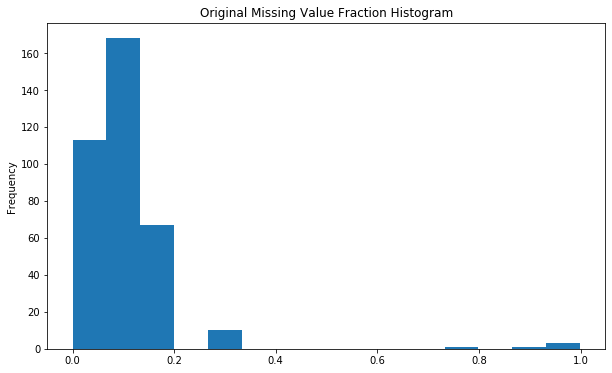

In [21]:
# check missing value fractions for each column
nan_num_frac = azdias_orig.isnull().mean()
print (nan_num_frac.sort_values(ascending=False))
nan_num_frac.sort_values().plot(kind='hist', bins=15, figsize=(10, 6))
plt.title('Original Missing Value Fraction Histogram')
plt.savefig('./outputs/orig_missing_value_hist.png')

In [22]:
# Define Class ProcessMissingValues which replace all missing values with np.nan 
class ProcessMissingValues(BaseEstimator, TransformerMixin):
    def __init__(self, attr_info):
        self.map = {}
        for i in range(len(attr_info)):
            missing_str = attr_info.missing_or_unknown[i]
            missing_list = missing_str.strip('[]').split(',')
            missing_list = [item for item in missing_list if item]
            for j in range(len(missing_list)):
                try:
                    num = int(missing_list[j])
                    missing_list.append(num)
                except:
                    continue
            self.map[attr_info.attribute[i]] = missing_list

    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        X_columns = list(X.columns)
        for col_name in self.map:
            if col_name in X_columns:
                print (f'replacing {col_name} missing values ... ')
                for item in self.map[col_name]:
                    X.loc[X[col_name]==item, col_name]=np.nan
        return X

In [23]:
# this step takes long to finish, the process results will be saved to a csv file 
process_missing_value = ProcessMissingValues(attr_info=azdias_attribute_info)
azdias_nan = process_missing_value.fit_transform(azdias_orig)

replacing AGER_TYP missing values ... 


C:\Miniconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


replacing ALTERSKATEGORIE_GROB missing values ... 
replacing ALTER_HH missing values ... 
replacing ANREDE_KZ missing values ... 
replacing ANZ_HAUSHALTE_AKTIV missing values ... 
replacing ANZ_HH_TITEL missing values ... 
replacing ANZ_PERSONEN missing values ... 
replacing ANZ_TITEL missing values ... 
replacing BALLRAUM missing values ... 
replacing CAMEO_DEUG_2015 missing values ... 
replacing CAMEO_DEU_2015 missing values ... 
replacing CAMEO_INTL_2015 missing values ... 
replacing CJT_GESAMTTYP missing values ... 
replacing D19_BANKEN_ANZ_12 missing values ... 
replacing D19_BANKEN_ANZ_24 missing values ... 
replacing D19_BANKEN_DATUM missing values ... 
replacing D19_BANKEN_DIREKT missing values ... 
replacing D19_BANKEN_GROSS missing values ... 
replacing D19_BANKEN_LOKAL missing values ... 
replacing D19_BANKEN_OFFLINE_DATUM missing values ... 
replacing D19_BANKEN_ONLINE_DATUM missing values ... 
replacing D19_BANKEN_ONLINE_QUOTE_12 missing values ... 
replacing D19_BANKEN_RE

replacing KBA13_HALTER_50 missing values ... 
replacing KBA13_HALTER_55 missing values ... 
replacing KBA13_HALTER_60 missing values ... 
replacing KBA13_HALTER_65 missing values ... 
replacing KBA13_HALTER_66 missing values ... 
replacing KBA13_HERST_ASIEN missing values ... 
replacing KBA13_HERST_AUDI_VW missing values ... 
replacing KBA13_HERST_BMW_BENZ missing values ... 
replacing KBA13_HERST_EUROPA missing values ... 
replacing KBA13_HERST_FORD_OPEL missing values ... 
replacing KBA13_HERST_SONST missing values ... 
replacing KBA13_KMH_110 missing values ... 
replacing KBA13_KMH_140 missing values ... 
replacing KBA13_KMH_180 missing values ... 
replacing KBA13_KMH_0_140 missing values ... 
replacing KBA13_KMH_140_210 missing values ... 
replacing KBA13_KMH_211 missing values ... 
replacing KBA13_KMH_250 missing values ... 
replacing KBA13_KMH_251 missing values ... 
replacing KBA13_KRSAQUOT missing values ... 
replacing KBA13_KRSHERST_AUDI_VW missing values ... 
replacing KBA13_

In [24]:
customers_nan = process_missing_value.transform(customers_orig)
mailout_train_nan = process_missing_value.transform(mailout_train)
mailout_test_nan = process_missing_value.transform(mailout_test)
print(f'There are {customers_nan.shape[1]} columns')
print(f'There are {mailout_train_nan.shape[1]} columns')
print(f'There are {mailout_test_nan.shape[1]} columns')

replacing AGER_TYP missing values ... 
replacing ALTERSKATEGORIE_GROB missing values ... 
replacing ALTER_HH missing values ... 
replacing ANREDE_KZ missing values ... 
replacing ANZ_HAUSHALTE_AKTIV missing values ... 
replacing ANZ_HH_TITEL missing values ... 
replacing ANZ_PERSONEN missing values ... 
replacing ANZ_TITEL missing values ... 
replacing BALLRAUM missing values ... 
replacing CAMEO_DEUG_2015 missing values ... 
replacing CAMEO_DEU_2015 missing values ... 
replacing CAMEO_INTL_2015 missing values ... 
replacing CJT_GESAMTTYP missing values ... 
replacing D19_BANKEN_ANZ_12 missing values ... 
replacing D19_BANKEN_ANZ_24 missing values ... 
replacing D19_BANKEN_DATUM missing values ... 
replacing D19_BANKEN_DIREKT missing values ... 
replacing D19_BANKEN_GROSS missing values ... 
replacing D19_BANKEN_LOKAL missing values ... 
replacing D19_BANKEN_OFFLINE_DATUM missing values ... 
replacing D19_BANKEN_ONLINE_DATUM missing values ... 
replacing D19_BANKEN_ONLINE_QUOTE_12 miss

replacing KBA13_HALTER_50 missing values ... 
replacing KBA13_HALTER_55 missing values ... 
replacing KBA13_HALTER_60 missing values ... 
replacing KBA13_HALTER_65 missing values ... 
replacing KBA13_HALTER_66 missing values ... 
replacing KBA13_HERST_ASIEN missing values ... 
replacing KBA13_HERST_AUDI_VW missing values ... 
replacing KBA13_HERST_BMW_BENZ missing values ... 
replacing KBA13_HERST_EUROPA missing values ... 
replacing KBA13_HERST_FORD_OPEL missing values ... 
replacing KBA13_HERST_SONST missing values ... 
replacing KBA13_KMH_110 missing values ... 
replacing KBA13_KMH_140 missing values ... 
replacing KBA13_KMH_180 missing values ... 
replacing KBA13_KMH_0_140 missing values ... 
replacing KBA13_KMH_140_210 missing values ... 
replacing KBA13_KMH_211 missing values ... 
replacing KBA13_KMH_250 missing values ... 
replacing KBA13_KMH_251 missing values ... 
replacing KBA13_KRSAQUOT missing values ... 
replacing KBA13_KRSHERST_AUDI_VW missing values ... 
replacing KBA13_

replacing FINANZ_MINIMALIST missing values ... 
replacing FINANZ_SPARER missing values ... 
replacing FINANZ_UNAUFFAELLIGER missing values ... 
replacing FINANZ_VORSORGER missing values ... 
replacing GEBAEUDETYP missing values ... 
replacing GEBAEUDETYP_RASTER missing values ... 
replacing GEBURTSJAHR missing values ... 
replacing GFK_URLAUBERTYP missing values ... 
replacing GREEN_AVANTGARDE missing values ... 
replacing HEALTH_TYP missing values ... 
replacing HH_EINKOMMEN_SCORE missing values ... 
replacing INNENSTADT missing values ... 
replacing KBA05_ALTER1 missing values ... 
replacing KBA05_ALTER2 missing values ... 
replacing KBA05_ALTER3 missing values ... 
replacing KBA05_ALTER4 missing values ... 
replacing KBA05_ANHANG missing values ... 
replacing KBA05_ANTG1 missing values ... 
replacing KBA05_ANTG2 missing values ... 
replacing KBA05_ANTG3 missing values ... 
replacing KBA05_ANTG4 missing values ... 
replacing KBA05_AUTOQUOT missing values ... 
replacing KBA05_BAUMAX m

replacing REGIOTYP missing values ... 
replacing RELAT_AB missing values ... 
replacing RETOURTYP_BK_S missing values ... 
replacing SEMIO_DOM missing values ... 
replacing SEMIO_ERL missing values ... 
replacing SEMIO_FAM missing values ... 
replacing SEMIO_KAEM missing values ... 
replacing SEMIO_KRIT missing values ... 
replacing SEMIO_KULT missing values ... 
replacing SEMIO_LUST missing values ... 
replacing SEMIO_MAT missing values ... 
replacing SEMIO_PFLICHT missing values ... 
replacing SEMIO_RAT missing values ... 
replacing SEMIO_REL missing values ... 
replacing SEMIO_SOZ missing values ... 
replacing SEMIO_TRADV missing values ... 
replacing SEMIO_VERT missing values ... 
replacing SHOPPER_TYP missing values ... 
replacing SOHO_KZ missing values ... 
replacing TITEL_KZ missing values ... 
replacing VERS_TYP missing values ... 
replacing WOHNDAUER_2008 missing values ... 
replacing WOHNLAGE missing values ... 
replacing W_KEIT_KIND_HH missing values ... 
replacing ZABEOTYP 

replacing KBA05_KRSAQUOT missing values ... 
replacing KBA05_KRSHERST1 missing values ... 
replacing KBA05_KRSHERST2 missing values ... 
replacing KBA05_KRSHERST3 missing values ... 
replacing KBA05_KRSKLEIN missing values ... 
replacing KBA05_KRSOBER missing values ... 
replacing KBA05_KRSVAN missing values ... 
replacing KBA05_KRSZUL missing values ... 
replacing KBA05_KW1 missing values ... 
replacing KBA05_KW2 missing values ... 
replacing KBA05_KW3 missing values ... 
replacing KBA05_MAXAH missing values ... 
replacing KBA05_MAXBJ missing values ... 
replacing KBA05_MAXHERST missing values ... 
replacing KBA05_MAXSEG missing values ... 
replacing KBA05_MAXVORB missing values ... 
replacing KBA05_MOD1 missing values ... 
replacing KBA05_MOD2 missing values ... 
replacing KBA05_MOD3 missing values ... 
replacing KBA05_MOD4 missing values ... 
replacing KBA05_MOD8 missing values ... 
replacing KBA05_MODTEMP missing values ... 
replacing KBA05_MOTOR missing values ... 
replacing KBA05

replacing SEMIO_VERT missing values ... 
replacing SHOPPER_TYP missing values ... 
replacing SOHO_KZ missing values ... 
replacing TITEL_KZ missing values ... 
replacing VERS_TYP missing values ... 
replacing WOHNDAUER_2008 missing values ... 
replacing WOHNLAGE missing values ... 
replacing W_KEIT_KIND_HH missing values ... 
replacing ZABEOTYP missing values ... 
replacing ARBEIT missing values ... 
replacing AKT_DAT_KL missing values ... 
replacing ALTERSKATEGORIE_FEIN missing values ... 
replacing ALTER_KIND1 missing values ... 
replacing ALTER_KIND2 missing values ... 
replacing ALTER_KIND3 missing values ... 
replacing ALTER_KIND4 missing values ... 
replacing ANZ_KINDER missing values ... 
replacing ANZ_STATISTISCHE_HAUSHALTE missing values ... 
replacing CJT_KATALOGNUTZER missing values ... 
replacing CJT_TYP_1 missing values ... 
replacing CJT_TYP_2 missing values ... 
replacing CJT_TYP_3 missing values ... 
replacing CJT_TYP_4 missing values ... 
replacing CJT_TYP_5 missing va

In [25]:
# # save processed data to csv, use index=False to skip index
# azdias_nan.to_csv('./data/azdias_nan.csv', sep=';', index = False)
# customers_nan.to_csv('./data/customers_nan.csv', sep=';', index = False)
# mailout_train_nan.to_csv('./data/mailout_train_nan.csv', sep=';', index = False)
# mailout_test_nan.to_csv('./data/mailout_test_nan.csv', sep=';', index = False)

In [26]:
# # reload processed data
# azdias_nan = pd.read_csv('./data/azdias_nan.csv', sep=';')
# customers_nan = pd.read_csv('./data/customers_nan.csv', sep=';')
# mailout_train_nan = pd.read_csv('./data/mailout_train_nan.csv', sep=';')
# mailout_test_nan = pd.read_csv('./data/mailout_test_nan.csv', sep=';')

In [27]:
azdias_nan.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0
1,NaN,9.0,NaN,NaN,NaN,NaN,NaN,21.0,11.0,0.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0
2,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,0.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0
3,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,0.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3.0,2.0,4.0
4,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,0.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4.0,1.0,3.0


## find out how many missing values per column

0.11522814324037693


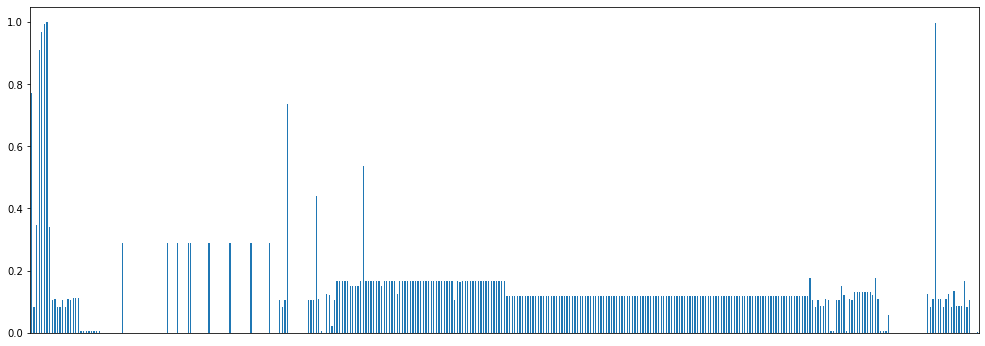

In [29]:
nan_num_frac = azdias_nan.isnull().mean()
print (nan_num_frac.mean())

nan_num_frac.plot(kind='bar', figsize=(17, 6))
plt.xticks([])
plt.show()

In [30]:
nan_num_sorted_frac = azdias_nan.isnull().mean().sort_values(ascending=False)
nan_num_sorted_frac.head(20)

ALTER_KIND4                    0.998648
TITEL_KZ                       0.997576
ALTER_KIND3                    0.993077
ALTER_KIND2                    0.966900
ALTER_KIND1                    0.909048
AGER_TYP                       0.769554
EXTSEL992                      0.733996
KBA05_BAUMAX                   0.534687
GEBURTSJAHR                    0.440203
ALTER_HH                       0.348137
ALTERSKATEGORIE_FEIN           0.341257
D19_TELKO_ONLINE_QUOTE_12      0.288495
D19_VERSI_ONLINE_QUOTE_12      0.288495
D19_VERSAND_ONLINE_QUOTE_12    0.288495
D19_LETZTER_KAUF_BRANCHE       0.288495
D19_SOZIALES                   0.288495
D19_LOTTO                      0.288495
D19_KONSUMTYP                  0.288495
D19_GESAMT_ONLINE_QUOTE_12     0.288495
D19_BANKEN_ONLINE_QUOTE_12     0.288495
dtype: float64

If the fraction of missing values is too large, it's not very reasonable to include the attribute for data analysis and modeling. Base on the plot and the missing value fraction numbers, a reasonable cutoff line is 0.3.

There are 11 attributes with more then 30% missing values

In [31]:
len(nan_num_sorted_frac[nan_num_sorted_frac>0.30].sort_index())

11

Now, let drop these columns for all dataframes

In [33]:
# drop columns with more than 60% missing values
threshold = 0.30
columns_nan = azdias_nan.columns
columns_nan
columns_nan_to_drop = list(nan_num_frac[nan_num_frac > threshold].index)
print('Dropping these columns', columns_nan_to_drop)
print(f'Dropping {len(columns_nan_to_drop)} columns')
print ()
print('The shape of data frame beofre dropping is', azdias_nan.shape)
azdias_select_cols = azdias_nan.drop(columns_nan_to_drop, axis=1, inplace=False)
print('The shape of data frame after dropping is', azdias_select_cols.shape)
print ()
print('The shape of data frame beofre dropping is', customers_nan.shape)
customers_select_cols = customers_nan.drop(columns_nan_to_drop, axis=1, inplace=False)
print('The shape of data frame after dropping is', customers_select_cols.shape)
print ()
print('The shape of data frame beofre dropping is', mailout_train_nan.shape)
mailout_train_select_cols = mailout_train_nan.drop(columns_nan_to_drop, axis=1, inplace=False)
print('The shape of data frame after dropping is', mailout_train_select_cols.shape)
print ()
print('The shape of data frame beofre dropping is', mailout_test_nan.shape)
mailout_test_select_cols = mailout_test_nan.drop(columns_nan_to_drop, axis=1, inplace=False)
print('The shape of data frame after dropping is', mailout_test_select_cols.shape)

Dropping these columns ['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'EXTSEL992', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'TITEL_KZ']
Dropping 11 columns

The shape of data frame beofre dropping is (891221, 363)
The shape of data frame after dropping is (891221, 352)

The shape of data frame beofre dropping is (191652, 366)
The shape of data frame after dropping is (191652, 355)

The shape of data frame beofre dropping is (42962, 364)
The shape of data frame after dropping is (42962, 353)

The shape of data frame beofre dropping is (42833, 363)
The shape of data frame after dropping is (42833, 352)


0.09600776184888739


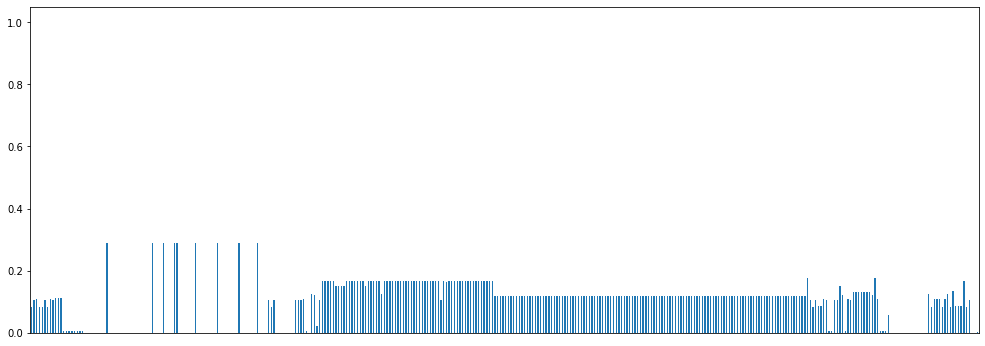

In [34]:
nan_num_frac = azdias_select_cols.isnull().mean()
print (nan_num_frac.mean())

nan_num_frac.plot(kind='bar', figsize=(17, 6))
plt.xticks([])
plt.ylim(0, 1.05)
plt.show()

### Select and Re-Encode Features

categorical     49
mixed            7
numeric         13
onehot           1
ordinal        283
Name: type, dtype: int64


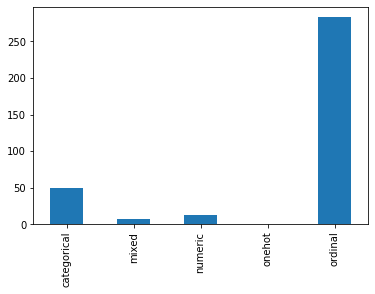

In [36]:
# summarize feature types
current_cols = list(azdias_select_cols.columns)
current_azdias_attribute_info = azdias_attribute_info[azdias_attribute_info.attribute.isin(current_cols)]
print(current_azdias_attribute_info.type.value_counts().sort_index())
current_azdias_attribute_info.type.value_counts().sort_index().plot(kind='bar')

### Categorical Features

print all categorical feature unique values

In [37]:
categorical_features = list(current_azdias_attribute_info[current_azdias_attribute_info.type == 'categorical']['attribute'])
for col in categorical_features:
    print (f'{col}: {azdias_select_cols[col].unique()}')

ANREDE_KZ: [1. 2.]
CAMEO_DEUG_2015: [nan 8.0 4.0 2.0 6.0 1.0 9.0 5.0 7.0 3.0 '4' '3' '7' '2' '8' '9' '6' '5'
 '1']
CAMEO_DEU_2015: [nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C']
CJT_GESAMTTYP: [ 2.  5.  3.  4.  1.  6. nan]
D19_BANKEN_DIREKT: [0 1 6 5 4 3 7 2]
D19_BANKEN_GROSS: [0 2 6 3 5 1 4]
D19_BANKEN_LOKAL: [0 7 3 6 5 2 1 4]
GEBAEUDETYP: [nan  8.  1.  3.  2.  6.  4.  5.]
GFK_URLAUBERTYP: [10.  1.  5. 12.  9.  3.  8. 11.  4.  2.  7.  6. nan]
GREEN_AVANTGARDE: [0 1]
KBA05_MODTEMP: [nan  1.  4.  3.  5.  2.  6.]
KBA05_SEG6: [nan  1.  0.]
LP_FAMILIE_FEIN: [ 2.  5.  1. nan 10.  7. 11.  3.  8.  4.  6.  9.]
LP_FAMILIE_GROB: [ 2.  3.  1. nan  5.  4.]
LP_STATUS_FEIN: [ 1.  2.  3.  9.  4. 10.  5.  8.  6.  7. nan]
LP_STATUS_GROB: [ 1.  2.  4.  5.  3. nan]
NATIONALITAET_KZ: [nan  1.  3.  2.]
OST_WEST_KZ: [nan 'W' 'O'

`CAMEO_DEUG_2015` have mixed type, and need to be converted to float

In [38]:
azdias_select_cols['CAMEO_DEUG_2015'] = azdias_select_cols['CAMEO_DEUG_2015'].astype('float32')
customers_select_cols['CAMEO_DEUG_2015'] = customers_select_cols['CAMEO_DEUG_2015'].astype('float32')
mailout_train_select_cols['CAMEO_DEUG_2015'] = mailout_train_select_cols['CAMEO_DEUG_2015'].astype('float32')
mailout_test_select_cols['CAMEO_DEUG_2015'] = mailout_test_select_cols['CAMEO_DEUG_2015'].astype('float32')

azdias_select_cols['CAMEO_DEUG_2015'].unique()

array([nan,  8.,  4.,  2.,  6.,  1.,  9.,  5.,  7.,  3.])

`OST_WEST_KZ` have non-numerical values, and need to be encoded to binary values

In [39]:
# change the non-digit binary category into digits
azdias_select_cols.loc[azdias_select_cols['OST_WEST_KZ']=='W','OST_WEST_KZ']=1.
azdias_select_cols.loc[azdias_select_cols['OST_WEST_KZ']=='O','OST_WEST_KZ']=2.

customers_select_cols.loc[customers_select_cols['OST_WEST_KZ']=='W','OST_WEST_KZ']=1.
customers_select_cols.loc[customers_select_cols['OST_WEST_KZ']=='O','OST_WEST_KZ']=2.

mailout_train_select_cols.loc[mailout_train_select_cols['OST_WEST_KZ']=='W','OST_WEST_KZ']=1.
mailout_train_select_cols.loc[mailout_train_select_cols['OST_WEST_KZ']=='O','OST_WEST_KZ']=2.

mailout_test_select_cols.loc[mailout_test_select_cols['OST_WEST_KZ']=='W','OST_WEST_KZ']=1.
mailout_test_select_cols.loc[mailout_test_select_cols['OST_WEST_KZ']=='O','OST_WEST_KZ']=2.

for all categorical attributes, a common missing value handling method is to replace the missing values with the `most_frequent` value for the dataset

In [40]:
# fill missing values with most frequent value
imputer = SimpleImputer(strategy='most_frequent')
azdias_select_cols[categorical_features] = imputer.fit_transform(azdias_select_cols[categorical_features])
customers_select_cols[categorical_features] = imputer.fit_transform(customers_select_cols[categorical_features])

mailout_train_select_cols[categorical_features] = imputer.fit_transform(mailout_train_select_cols[categorical_features])
mailout_test_select_cols[categorical_features] = imputer.transform(mailout_test_select_cols[categorical_features])

for col in categorical_features:
    print (f'{col}: {azdias_select_cols[col].unique()}')

ANREDE_KZ: [1. 2.]
CAMEO_DEUG_2015: [8. 4. 2. 6. 1. 9. 5. 7. 3.]
CAMEO_DEU_2015: ['6B' '8A' '4C' '2A' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C']
CJT_GESAMTTYP: [2. 5. 3. 4. 1. 6.]
D19_BANKEN_DIREKT: [0 1 6 5 4 3 7 2]
D19_BANKEN_GROSS: [0 2 6 3 5 1 4]
D19_BANKEN_LOKAL: [0 7 3 6 5 2 1 4]
GEBAEUDETYP: [1. 8. 3. 2. 6. 4. 5.]
GFK_URLAUBERTYP: [10.  1.  5. 12.  9.  3.  8. 11.  4.  2.  7.  6.]
GREEN_AVANTGARDE: [0 1]
KBA05_MODTEMP: [3. 1. 4. 5. 2. 6.]
KBA05_SEG6: [0. 1.]
LP_FAMILIE_FEIN: [ 2.  5.  1. 10.  7. 11.  3.  8.  4.  6.  9.]
LP_FAMILIE_GROB: [2. 3. 1. 5. 4.]
LP_STATUS_FEIN: [ 1.  2.  3.  9.  4. 10.  5.  8.  6.  7.]
LP_STATUS_GROB: [1. 2. 4. 5. 3.]
NATIONALITAET_KZ: [1. 3. 2.]
OST_WEST_KZ: [1. 2.]
SHOPPER_TYP: [1. 3. 2. 0.]
SOHO_KZ: [0. 1.]
VERS_TYP: [2. 1.]
ZABEOTYP: [3. 5. 4. 1. 6. 2.]
AKT_DAT_KL: [1. 9. 5. 8. 7. 6. 4. 3. 2.]

After further investigating `CAMEO_DEU_2015`, it's very similar to `CAMEO_DEUG_2015`, I decided to drop `CAMEO_DEU_2015` to simplify the dataset

In [41]:
# Drop CAMEO_DEU_2015
azdias_select_cols.drop('CAMEO_DEU_2015', axis=1, inplace=True)
customers_select_cols.drop('CAMEO_DEU_2015', axis=1, inplace=True)
mailout_train_select_cols.drop('CAMEO_DEU_2015', axis=1, inplace=True)
mailout_test_select_cols.drop('CAMEO_DEU_2015', axis=1, inplace=True)
categorical_features.remove('CAMEO_DEU_2015')

In [42]:
# set categorical columns to 'category' type
for col in categorical_features:
    azdias_select_cols[col] = azdias_select_cols[col].astype('int32').astype('category')
    print (f'{col}: {azdias_select_cols[col].unique()}')

ANREDE_KZ: [1, 2]
Categories (2, int64): [1, 2]
CAMEO_DEUG_2015: [8, 4, 2, 6, 1, 9, 5, 7, 3]
Categories (9, int64): [8, 4, 2, 6, ..., 9, 5, 7, 3]
CJT_GESAMTTYP: [2, 5, 3, 4, 1, 6]
Categories (6, int64): [2, 5, 3, 4, 1, 6]
D19_BANKEN_DIREKT: [0, 1, 6, 5, 4, 3, 7, 2]
Categories (8, int64): [0, 1, 6, 5, 4, 3, 7, 2]
D19_BANKEN_GROSS: [0, 2, 6, 3, 5, 1, 4]
Categories (7, int64): [0, 2, 6, 3, 5, 1, 4]
D19_BANKEN_LOKAL: [0, 7, 3, 6, 5, 2, 1, 4]
Categories (8, int64): [0, 7, 3, 6, 5, 2, 1, 4]
GEBAEUDETYP: [1, 8, 3, 2, 6, 4, 5]
Categories (7, int64): [1, 8, 3, 2, 6, 4, 5]
GFK_URLAUBERTYP: [10, 1, 5, 12, 9, ..., 11, 4, 2, 7, 6]
Length: 12
Categories (12, int64): [10, 1, 5, 12, ..., 4, 2, 7, 6]
GREEN_AVANTGARDE: [0, 1]
Categories (2, int64): [0, 1]
KBA05_MODTEMP: [3, 1, 4, 5, 2, 6]
Categories (6, int64): [3, 1, 4, 5, 2, 6]
KBA05_SEG6: [0, 1]
Categories (2, int64): [0, 1]
LP_FAMILIE_FEIN: [2, 5, 1, 10, 7, ..., 3, 8, 4, 6, 9]
Length: 11
Categories (11, int64): [2, 5, 1, 10, ..., 8, 4, 6, 9]
LP_FAMI

### Mixed-Type Features

There are several mixed typed attributes, and they contain loaded properties, and need to be separated out help the analysis process. 
`CAMEO_INTL_2015` combines both wealth and life stage. I decided to split this attribute into two features `CAMEO_INTL_2015_WEALTH` and `CAMEO_INTL_2015_STATUS`

`PRAEGENDE_JUGENDJAHRE` combines several properties together as well, and need to be handled as well. 

Before doing that, missing values need to be replaced with the `most_frequent` values first

In [43]:
mixed_type_features = list(current_azdias_attribute_info[current_azdias_attribute_info.type == 'mixed']['attribute'])
for col in mixed_type_features:
    print (f'{col}: {azdias_select_cols[col].unique()}')

CAMEO_INTL_2015: [nan 51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 33.0 41.0 34.0 55.0 25.0
 23.0 31.0 52.0 35.0 45.0 44.0 32.0 '22' '24' '41' '12' '54' '51' '44'
 '35' '23' '25' '14' '34' '52' '55' '31' '32' '15' '13' '43' '33' '45']
LP_LEBENSPHASE_FEIN: [15. 21.  3. nan 32.  8.  2.  5. 10.  4.  6. 23. 12. 20.  1. 11. 25. 13.
  7. 18. 31. 19. 38. 35. 30. 22. 14. 33. 29. 24. 28. 37. 26. 39. 27. 36.
  9. 34. 40. 16. 17.]
LP_LEBENSPHASE_GROB: [ 4.  6.  1. nan 10.  2.  3.  5.  7. 12. 11.  9.  8.]
PLZ8_BAUMAX: [nan  1.  2.  4.  5.  3.]
PRAEGENDE_JUGENDJAHRE: [nan 14. 15.  8.  3. 10. 11.  5.  9.  6.  4.  2.  1. 12. 13.  7.]
WOHNLAGE: [nan  4.  2.  7.  3.  5.  1.  8.  0.]
KBA13_BAUMAX: [nan  2.  1.  4.  5.  3.]


In [44]:
azdias_select_cols['CAMEO_INTL_2015'] = azdias_select_cols['CAMEO_INTL_2015'].astype('float32')
customers_select_cols['CAMEO_INTL_2015'] = customers_select_cols['CAMEO_INTL_2015'].astype('float32')
mailout_train_select_cols['CAMEO_INTL_2015'] = mailout_train_select_cols['CAMEO_INTL_2015'].astype('float32')
mailout_test_select_cols['CAMEO_INTL_2015'] = mailout_test_select_cols['CAMEO_INTL_2015'].astype('float32')
azdias_select_cols['CAMEO_INTL_2015'].unique()

array([nan, 51., 24., 12., 43., 54., 22., 14., 13., 15., 33., 41., 34.,
       55., 25., 23., 31., 52., 35., 45., 44., 32.])

In [45]:
imputer_mixed_type = SimpleImputer(strategy='most_frequent')
azdias_select_cols[mixed_type_features] = imputer_mixed_type.fit_transform(azdias_select_cols[mixed_type_features])
customers_select_cols[mixed_type_features] = imputer_mixed_type.fit_transform(customers_select_cols[mixed_type_features])

mailout_train_select_cols[mixed_type_features] = imputer_mixed_type.fit_transform(mailout_train_select_cols[mixed_type_features])
mailout_test_select_cols[mixed_type_features] = imputer_mixed_type.transform(mailout_test_select_cols[mixed_type_features])

for col in mixed_type_features:
    print (f'{col}: {azdias_select_cols[col].unique()}')

CAMEO_INTL_2015: [51. 24. 12. 43. 54. 22. 14. 13. 15. 33. 41. 34. 55. 25. 23. 31. 52. 35.
 45. 44. 32.]
LP_LEBENSPHASE_FEIN: [15. 21.  3.  1. 32.  8.  2.  5. 10.  4.  6. 23. 12. 20. 11. 25. 13.  7.
 18. 31. 19. 38. 35. 30. 22. 14. 33. 29. 24. 28. 37. 26. 39. 27. 36.  9.
 34. 40. 16. 17.]
LP_LEBENSPHASE_GROB: [ 4.  6.  1.  2. 10.  3.  5.  7. 12. 11.  9.  8.]
PLZ8_BAUMAX: [1. 2. 4. 5. 3.]
PRAEGENDE_JUGENDJAHRE: [14. 15.  8.  3. 10. 11.  5.  9.  6.  4.  2.  1. 12. 13.  7.]
WOHNLAGE: [3. 4. 2. 7. 5. 1. 8. 0.]
KBA13_BAUMAX: [1. 2. 4. 5. 3.]


In [46]:
decade = {1: 4, 
          2: 4, 
          3: 5, 
          4: 5, 
          5: 6, 
          6: 6, 
          7: 6, 
          8: 7, 
          9: 7, 
          10: 8, 
          11: 8, 
          12: 8, 
          13: 8, 
          14: 9, 
          15: 9}
not_mainstream = {1: 1, 
                  2: 2, 
                  3: 1, 
                  4: 2, 
                  5: 1, 
                  6: 2, 
                  7: 2, 
                  8: 1, 
                  9: 2, 
                  10: 1, 
                  11: 2, 
                  12: 1, 
                  13: 2, 
                  14: 1, 
                  15: 2}

azdias_select_cols['PRAEGENDE_JUGENDJAHRE'] = azdias_select_cols['PRAEGENDE_JUGENDJAHRE'].astype('int8')
azdias_select_cols['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias_select_cols['PRAEGENDE_JUGENDJAHRE'].map(decade)
azdias_select_cols['PRAEGENDE_JUGENDJAHRE_NOT_MAINSTREAM'] = azdias_select_cols['PRAEGENDE_JUGENDJAHRE'].map(not_mainstream)
azdias_select_cols.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

customers_select_cols['PRAEGENDE_JUGENDJAHRE'] = customers_select_cols['PRAEGENDE_JUGENDJAHRE'].astype('int8')
customers_select_cols['PRAEGENDE_JUGENDJAHRE_DECADE'] = customers_select_cols['PRAEGENDE_JUGENDJAHRE'].map(decade)
customers_select_cols['PRAEGENDE_JUGENDJAHRE_NOT_MAINSTREAM'] = customers_select_cols['PRAEGENDE_JUGENDJAHRE'].map(not_mainstream)
customers_select_cols.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

mailout_train_select_cols['PRAEGENDE_JUGENDJAHRE'] = mailout_train_select_cols['PRAEGENDE_JUGENDJAHRE'].astype('int8')
mailout_train_select_cols['PRAEGENDE_JUGENDJAHRE_DECADE'] = mailout_train_select_cols['PRAEGENDE_JUGENDJAHRE'].map(decade)
mailout_train_select_cols['PRAEGENDE_JUGENDJAHRE_NOT_MAINSTREAM'] = mailout_train_select_cols['PRAEGENDE_JUGENDJAHRE'].map(not_mainstream)
mailout_train_select_cols.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

mailout_test_select_cols['PRAEGENDE_JUGENDJAHRE'] = mailout_test_select_cols['PRAEGENDE_JUGENDJAHRE'].astype('int8')
mailout_test_select_cols['PRAEGENDE_JUGENDJAHRE_DECADE'] = mailout_test_select_cols['PRAEGENDE_JUGENDJAHRE'].map(decade)
mailout_test_select_cols['PRAEGENDE_JUGENDJAHRE_NOT_MAINSTREAM'] = mailout_test_select_cols['PRAEGENDE_JUGENDJAHRE'].map(not_mainstream)
mailout_test_select_cols.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

mixed_type_features.remove('PRAEGENDE_JUGENDJAHRE')

In [47]:
PRAEGENDE_cols = ['PRAEGENDE_JUGENDJAHRE_DECADE', 'PRAEGENDE_JUGENDJAHRE_NOT_MAINSTREAM']
azdias_select_cols[PRAEGENDE_cols] = azdias_select_cols[PRAEGENDE_cols].astype('category')
customers_select_cols[PRAEGENDE_cols] = customers_select_cols[PRAEGENDE_cols].astype('category')
mailout_train_select_cols[PRAEGENDE_cols] = mailout_train_select_cols[PRAEGENDE_cols].astype('category')
mailout_test_select_cols[PRAEGENDE_cols] = mailout_test_select_cols[PRAEGENDE_cols].astype('category')

In [48]:
for col in PRAEGENDE_cols:
    print (f'{col}: {azdias_select_cols[col].unique()}')

PRAEGENDE_JUGENDJAHRE_DECADE: [9, 7, 5, 8, 6, 4]
Categories (6, int64): [9, 7, 5, 8, 6, 4]
PRAEGENDE_JUGENDJAHRE_NOT_MAINSTREAM: [1, 2]
Categories (2, int64): [1, 2]


In [49]:
azdias_select_cols['CAMEO_INTL_2015'] = azdias_select_cols['CAMEO_INTL_2015'].astype('int8')
azdias_select_cols['CAMEO_INTL_2015_WEALTH'] = azdias_select_cols['CAMEO_INTL_2015'].apply(lambda x: x//10)
azdias_select_cols['CAMEO_INTL_2015_STATUS'] = azdias_select_cols['CAMEO_INTL_2015'].apply(lambda x: x%10)
azdias_select_cols.drop('CAMEO_INTL_2015', axis=1, inplace=True)

customers_select_cols['CAMEO_INTL_2015'] = customers_select_cols['CAMEO_INTL_2015'].astype('int8')
customers_select_cols['CAMEO_INTL_2015_WEALTH'] = customers_select_cols['CAMEO_INTL_2015'].apply(lambda x: x//10)
customers_select_cols['CAMEO_INTL_2015_STATUS'] = customers_select_cols['CAMEO_INTL_2015'].apply(lambda x: x%10)
customers_select_cols.drop('CAMEO_INTL_2015', axis=1, inplace=True)

mailout_train_select_cols['CAMEO_INTL_2015'] = mailout_train_select_cols['CAMEO_INTL_2015'].astype('int8')
mailout_train_select_cols['CAMEO_INTL_2015_WEALTH'] = mailout_train_select_cols['CAMEO_INTL_2015'].apply(lambda x: x//10)
mailout_train_select_cols['CAMEO_INTL_2015_STATUS'] = mailout_train_select_cols['CAMEO_INTL_2015'].apply(lambda x: x%10)
mailout_train_select_cols.drop('CAMEO_INTL_2015', axis=1, inplace=True)

mailout_test_select_cols['CAMEO_INTL_2015'] = mailout_test_select_cols['CAMEO_INTL_2015'].astype('int8')
mailout_test_select_cols['CAMEO_INTL_2015_WEALTH'] = mailout_test_select_cols['CAMEO_INTL_2015'].apply(lambda x: x//10)
mailout_test_select_cols['CAMEO_INTL_2015_STATUS'] = mailout_test_select_cols['CAMEO_INTL_2015'].apply(lambda x: x%10)
mailout_test_select_cols.drop('CAMEO_INTL_2015', axis=1, inplace=True)

mixed_type_features.remove('CAMEO_INTL_2015')

In [50]:
CAMEO_INTL_2015_cols = ['CAMEO_INTL_2015_WEALTH', 'CAMEO_INTL_2015_STATUS']
azdias_select_cols[CAMEO_INTL_2015_cols] = azdias_select_cols[CAMEO_INTL_2015_cols].astype('category')
customers_select_cols[CAMEO_INTL_2015_cols] = customers_select_cols[CAMEO_INTL_2015_cols].astype('category')
mailout_train_select_cols[CAMEO_INTL_2015_cols] = mailout_train_select_cols[CAMEO_INTL_2015_cols].astype('category')
mailout_test_select_cols[CAMEO_INTL_2015_cols] = mailout_test_select_cols[CAMEO_INTL_2015_cols].astype('category')

In [51]:
for col in CAMEO_INTL_2015_cols:
    print (f'{col}: {azdias_select_cols[col].unique()}')

CAMEO_INTL_2015_WEALTH: [5, 2, 1, 4, 3]
Categories (5, int64): [5, 2, 1, 4, 3]
CAMEO_INTL_2015_STATUS: [1, 4, 2, 3, 5]
Categories (5, int64): [1, 4, 2, 3, 5]


`LP_LEBENSPHASE_FEIN` and `LP_LEBENSPHASE_GROB` are not very relevant, and I decided to drop them. 

In [52]:
# Drop Remove:LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB
azdias_select_cols.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'], axis=1, inplace=True)
customers_select_cols.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'], axis=1, inplace=True)
mailout_train_select_cols.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'], axis=1, inplace=True)
mailout_test_select_cols.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'], axis=1, inplace=True)
mixed_type_features.remove('LP_LEBENSPHASE_FEIN')
mixed_type_features.remove('LP_LEBENSPHASE_GROB')

In [53]:
mixed_type_features += CAMEO_INTL_2015_cols + PRAEGENDE_cols
mixed_type_features

['PLZ8_BAUMAX',
 'WOHNLAGE',
 'KBA13_BAUMAX',
 'CAMEO_INTL_2015_WEALTH',
 'CAMEO_INTL_2015_STATUS',
 'PRAEGENDE_JUGENDJAHRE_DECADE',
 'PRAEGENDE_JUGENDJAHRE_NOT_MAINSTREAM']

In [54]:
for col in mixed_type_features:
    print (f'{col}: {azdias_select_cols[col].unique()}')

PLZ8_BAUMAX: [1. 2. 4. 5. 3.]
WOHNLAGE: [3. 4. 2. 7. 5. 1. 8. 0.]
KBA13_BAUMAX: [1. 2. 4. 5. 3.]
CAMEO_INTL_2015_WEALTH: [5, 2, 1, 4, 3]
Categories (5, int64): [5, 2, 1, 4, 3]
CAMEO_INTL_2015_STATUS: [1, 4, 2, 3, 5]
Categories (5, int64): [1, 4, 2, 3, 5]
PRAEGENDE_JUGENDJAHRE_DECADE: [9, 7, 5, 8, 6, 4]
Categories (6, int64): [9, 7, 5, 8, 6, 4]
PRAEGENDE_JUGENDJAHRE_NOT_MAINSTREAM: [1, 2]
Categories (2, int64): [1, 2]


### Ordinal Features

In [55]:
ordinal_features = list(current_azdias_attribute_info[current_azdias_attribute_info.type == 'ordinal']['attribute'])
for col in ordinal_features:
    print (f'{col}: {azdias_select_cols[col].unique()}')

ALTERSKATEGORIE_GROB: [ 2.  1.  3.  4. nan]
BALLRAUM: [nan  6.  2.  4.  3.  7.  1.  5.]
D19_BANKEN_ANZ_12: [0 3 1 2 4 5 6]
D19_BANKEN_ANZ_24: [0 5 1 2 4 3 6]
D19_BANKEN_DATUM: [10  5  8  6  9  1  7  4  2  3]
D19_BANKEN_OFFLINE_DATUM: [10  9  8  2  5  4  1  6  7  3]
D19_BANKEN_ONLINE_DATUM: [10  5  8  6  9  1  4  7  2  3]
D19_BANKEN_ONLINE_QUOTE_12: [nan  0. 10.  8.  5.  9.  7.  6.  3.  4.  2.  1.]
D19_BANKEN_REST: [0 6 5 4 3 7 2 1]
D19_BEKLEIDUNG_GEH: [0 6 5 7 3 2 4 1]
D19_BEKLEIDUNG_REST: [0 1 6 7 5 3 4 2]
D19_BILDUNG: [0 6 3 7 2 4 5 1]
D19_BIO_OEKO: [0 6 7 3 5 2 4 1]
D19_BUCH_CD: [0 6 5 3 1 7 4 2]
D19_DIGIT_SERV: [0 6 7 3 5 2 4 1]
D19_DROGERIEARTIKEL: [0 1 6 3 7 4 5 2]
D19_ENERGIE: [0 5 3 6 7 2 1 4]
D19_FREIZEIT: [0 7 3 6 5 4 1 2]
D19_GARTEN: [0 3 6 7 5 4 2 1]
D19_GESAMT_ANZ_12: [0 6 1 2 3 4 5]
D19_GESAMT_ANZ_24: [0 6 1 2 3 5 4]
D19_GESAMT_DATUM: [10  1  3  5  9  4  7  6  8  2]
D19_GESAMT_OFFLINE_DATUM: [10  6  8  9  5  2  4  1  7  3]
D19_GESAMT_ONLINE_DATUM: [10  1  3  5  9  4  7  6

KBA13_KW_70: [nan  1.  4.  3.  2.  0.  5.]
KBA13_KW_61_120: [nan  3.  5.  2.  4.  1.]
KBA13_KW_80: [nan  2.  4.  1.  3.  0.  5.]
KBA13_KW_90: [nan  3.  2.  0.  4.  1.  5.]
KBA13_KW_110: [nan  4.  3.  1.  5.  0.  2.]
KBA13_KW_120: [nan  4.  3.  1.  5.  0.  2.]
KBA13_KW_121: [nan  3.  4.  5.  2.  0.  1.]
KBA13_MAZDA: [nan  2.  3.  4.  5.  1.]
KBA13_MERCEDES: [nan  4.  3.  5.  2.  1.]
KBA13_MOTOR: [nan  3.  4.  2.  1.]
KBA13_NISSAN: [nan  2.  3.  5.  4.  1.]
KBA13_OPEL: [nan  3.  2.  4.  1.  5.]
KBA13_PEUGEOT: [nan  4.  3.  2.  1.  5.]
KBA13_RENAULT: [nan  3.  2.  4.  5.  1.]
KBA13_SEG_GELAENDEWAGEN: [nan  2.  5.  3.  4.  1.]
KBA13_SEG_GROSSRAUMVANS: [nan  3.  4.  1.  5.  2.]
KBA13_SEG_KLEINST: [nan  2.  3.  5.  4.  1.]
KBA13_SEG_KLEINWAGEN: [nan  2.  3.  4.  1.  5.]
KBA13_SEG_KOMPAKTKLASSE: [nan  5.  1.  4.  3.  2.]
KBA13_SEG_MINIVANS: [nan  4.  3.  2.  1.  5.]
KBA13_SEG_MINIWAGEN: [nan  2.  3.  5.  4.  1.]
KBA13_SEG_MITTELKLASSE: [nan  3.  2.  4.  5.  1.]
KBA13_SEG_OBEREMITTELKLASSE: [n

for several ordinal attributes, value 10 needs to be converted to 0 to make the value meaningful as ordinal variables. 

In [56]:
for col in convert_10_to_0_list:
    if col in list(azdias_select_cols.columns):
        azdias_select_cols[col] = azdias_select_cols[col].apply(lambda x: x%10)
        customers_select_cols[col] = customers_select_cols[col].apply(lambda x: x%10)
        mailout_train_select_cols[col] = mailout_train_select_cols[col].apply(lambda x: x%10)
        mailout_test_select_cols[col] = mailout_test_select_cols[col].apply(lambda x: x%10)

for col in ordinal_features:
    print (f'{col}: {azdias_select_cols[col].unique()}')

ALTERSKATEGORIE_GROB: [ 2.  1.  3.  4. nan]
BALLRAUM: [nan  6.  2.  4.  3.  7.  1.  5.]
D19_BANKEN_ANZ_12: [0 3 1 2 4 5 6]
D19_BANKEN_ANZ_24: [0 5 1 2 4 3 6]
D19_BANKEN_DATUM: [0 5 8 6 9 1 7 4 2 3]
D19_BANKEN_OFFLINE_DATUM: [0 9 8 2 5 4 1 6 7 3]
D19_BANKEN_ONLINE_DATUM: [0 5 8 6 9 1 4 7 2 3]
D19_BANKEN_ONLINE_QUOTE_12: [nan  0. 10.  8.  5.  9.  7.  6.  3.  4.  2.  1.]
D19_BANKEN_REST: [0 6 5 4 3 7 2 1]
D19_BEKLEIDUNG_GEH: [0 6 5 7 3 2 4 1]
D19_BEKLEIDUNG_REST: [0 1 6 7 5 3 4 2]
D19_BILDUNG: [0 6 3 7 2 4 5 1]
D19_BIO_OEKO: [0 6 7 3 5 2 4 1]
D19_BUCH_CD: [0 6 5 3 1 7 4 2]
D19_DIGIT_SERV: [0 6 7 3 5 2 4 1]
D19_DROGERIEARTIKEL: [0 1 6 3 7 4 5 2]
D19_ENERGIE: [0 5 3 6 7 2 1 4]
D19_FREIZEIT: [0 7 3 6 5 4 1 2]
D19_GARTEN: [0 3 6 7 5 4 2 1]
D19_GESAMT_ANZ_12: [0 6 1 2 3 4 5]
D19_GESAMT_ANZ_24: [0 6 1 2 3 5 4]
D19_GESAMT_DATUM: [0 1 3 5 9 4 7 6 8 2]
D19_GESAMT_OFFLINE_DATUM: [0 6 8 9 5 2 4 1 7 3]
D19_GESAMT_ONLINE_DATUM: [0 1 3 5 9 4 7 6 8 2]
D19_GESAMT_ONLINE_QUOTE_12: [nan  0. 10.  7.  9.  5.

KBA13_KW_90: [nan  3.  2.  0.  4.  1.  5.]
KBA13_KW_110: [nan  4.  3.  1.  5.  0.  2.]
KBA13_KW_120: [nan  4.  3.  1.  5.  0.  2.]
KBA13_KW_121: [nan  3.  4.  5.  2.  0.  1.]
KBA13_MAZDA: [nan  2.  3.  4.  5.  1.]
KBA13_MERCEDES: [nan  4.  3.  5.  2.  1.]
KBA13_MOTOR: [nan  3.  4.  2.  1.]
KBA13_NISSAN: [nan  2.  3.  5.  4.  1.]
KBA13_OPEL: [nan  3.  2.  4.  1.  5.]
KBA13_PEUGEOT: [nan  4.  3.  2.  1.  5.]
KBA13_RENAULT: [nan  3.  2.  4.  5.  1.]
KBA13_SEG_GELAENDEWAGEN: [nan  2.  5.  3.  4.  1.]
KBA13_SEG_GROSSRAUMVANS: [nan  3.  4.  1.  5.  2.]
KBA13_SEG_KLEINST: [nan  2.  3.  5.  4.  1.]
KBA13_SEG_KLEINWAGEN: [nan  2.  3.  4.  1.  5.]
KBA13_SEG_KOMPAKTKLASSE: [nan  5.  1.  4.  3.  2.]
KBA13_SEG_MINIVANS: [nan  4.  3.  2.  1.  5.]
KBA13_SEG_MINIWAGEN: [nan  2.  3.  5.  4.  1.]
KBA13_SEG_MITTELKLASSE: [nan  3.  2.  4.  5.  1.]
KBA13_SEG_OBEREMITTELKLASSE: [nan  3.  4.  5.  2.  1.]
KBA13_SEG_OBERKLASSE: [nan  3.  1.  4.  5.  0.  2.]
KBA13_SEG_SONSTIGE: [nan  2.  5.  3.  4.  1.]
KBA13_S

Missing values also need to be replaced with `most_frequent` values

In [57]:
imputer_ordinal_type = SimpleImputer(strategy='most_frequent')
azdias_select_cols[ordinal_features] = imputer_ordinal_type.fit_transform(azdias_select_cols[ordinal_features])
customers_select_cols[ordinal_features] = imputer_ordinal_type.fit_transform(customers_select_cols[ordinal_features])

mailout_train_select_cols[ordinal_features] = imputer_ordinal_type.fit_transform(mailout_train_select_cols[ordinal_features])
mailout_test_select_cols[ordinal_features] = imputer_ordinal_type.transform(mailout_test_select_cols[ordinal_features])

for col in ordinal_features:
    print (f'{col}: {azdias_select_cols[col].unique()}')

ALTERSKATEGORIE_GROB: [2. 1. 3. 4.]
BALLRAUM: [6. 2. 4. 3. 7. 1. 5.]
D19_BANKEN_ANZ_12: [0. 3. 1. 2. 4. 5. 6.]
D19_BANKEN_ANZ_24: [0. 5. 1. 2. 4. 3. 6.]
D19_BANKEN_DATUM: [0. 5. 8. 6. 9. 1. 7. 4. 2. 3.]
D19_BANKEN_OFFLINE_DATUM: [0. 9. 8. 2. 5. 4. 1. 6. 7. 3.]
D19_BANKEN_ONLINE_DATUM: [0. 5. 8. 6. 9. 1. 4. 7. 2. 3.]
D19_BANKEN_ONLINE_QUOTE_12: [ 0. 10.  8.  5.  9.  7.  6.  3.  4.  2.  1.]
D19_BANKEN_REST: [0. 6. 5. 4. 3. 7. 2. 1.]
D19_BEKLEIDUNG_GEH: [0. 6. 5. 7. 3. 2. 4. 1.]
D19_BEKLEIDUNG_REST: [0. 1. 6. 7. 5. 3. 4. 2.]
D19_BILDUNG: [0. 6. 3. 7. 2. 4. 5. 1.]
D19_BIO_OEKO: [0. 6. 7. 3. 5. 2. 4. 1.]
D19_BUCH_CD: [0. 6. 5. 3. 1. 7. 4. 2.]
D19_DIGIT_SERV: [0. 6. 7. 3. 5. 2. 4. 1.]
D19_DROGERIEARTIKEL: [0. 1. 6. 3. 7. 4. 5. 2.]
D19_ENERGIE: [0. 5. 3. 6. 7. 2. 1. 4.]
D19_FREIZEIT: [0. 7. 3. 6. 5. 4. 1. 2.]
D19_GARTEN: [0. 3. 6. 7. 5. 4. 2. 1.]
D19_GESAMT_ANZ_12: [0. 6. 1. 2. 3. 4. 5.]
D19_GESAMT_ANZ_24: [0. 6. 1. 2. 3. 5. 4.]
D19_GESAMT_DATUM: [0. 1. 3. 5. 9. 4. 7. 6. 8. 2.]
D19_GESAMT_OFF

PLZ8_HHZ: [3. 5. 4. 2. 1.]
REGIOTYP: [6. 3. 2. 5. 1. 7. 4.]
RELAT_AB: [3. 4. 2. 5. 1.]
RETOURTYP_BK_S: [5. 1. 3. 2. 4.]
SEMIO_DOM: [6. 7. 4. 2. 1. 5. 3.]
SEMIO_ERL: [3. 2. 6. 7. 4. 5. 1.]
SEMIO_FAM: [6. 4. 1. 5. 7. 2. 3.]
SEMIO_KAEM: [6. 4. 7. 5. 2. 3. 1.]
SEMIO_KRIT: [7. 4. 3. 1. 5. 6. 2.]
SEMIO_KULT: [3. 4. 6. 5. 7. 1. 2.]
SEMIO_LUST: [5. 2. 4. 6. 7. 3. 1.]
SEMIO_MAT: [5. 3. 1. 2. 4. 7. 6.]
SEMIO_PFLICHT: [5. 7. 3. 4. 1. 6. 2.]
SEMIO_RAT: [4. 6. 3. 2. 7. 5. 1.]
SEMIO_REL: [7. 4. 3. 2. 5. 1. 6.]
SEMIO_SOZ: [2. 5. 4. 6. 7. 3. 1.]
SEMIO_TRADV: [3. 6. 4. 2. 7. 5. 1.]
SEMIO_VERT: [1. 4. 7. 2. 6. 5. 3.]
WOHNDAUER_2008: [9. 8. 3. 4. 5. 6. 2. 7. 1.]
W_KEIT_KIND_HH: [6. 3. 2. 5. 4. 1.]
ARBEIT: [4. 3. 2. 1. 5.]
D19_TELKO_ONLINE_QUOTE_12: [0. 5. 7. 3.]
D19_VERSI_DATUM: [0. 2. 8. 9. 6. 7. 5. 1. 4. 3.]
D19_VERSI_OFFLINE_DATUM: [0. 7. 9. 6. 4. 8. 5. 2. 3. 1.]
D19_VERSI_ONLINE_DATUM: [0. 8. 9. 5. 6. 7. 4. 1. 2. 3.]
D19_VERSI_ONLINE_QUOTE_12: [ 0. 10.  5.  7.  8.  6.  3.  9.]
KBA13_ANTG1: [2. 1. 4. 

In [58]:
azdias_select_cols[ordinal_features] = azdias_select_cols[ordinal_features].astype('int32').astype('category')
customers_select_cols[ordinal_features] = customers_select_cols[ordinal_features].astype('int32').astype('category')
mailout_train_select_cols[ordinal_features] = mailout_train_select_cols[ordinal_features].astype('int32').astype('category')
mailout_test_select_cols[ordinal_features] = mailout_test_select_cols[ordinal_features].astype('int32').astype('category')

### Onehot Features

Traditinally, categorical features need to be onehot-encoded; however, for this dataset, most of the categorical features are semi-oridinal, and we may come through without onehot encoding.

Meanwhile, there is one feature `D19_LETZTER_KAUF_BRANCHE` which is necessary  to be onehot-encoded or dropped. I specify this one as onehot_feature for this project. 

In [61]:
onehot_features = list(current_azdias_attribute_info[current_azdias_attribute_info.type == 'onehot']['attribute'])
for col in onehot_features:
    print (f'{col}: {azdias_select_cols[col].unique()}')

D19_LETZTER_KAUF_BRANCHE: [nan 'D19_UNBEKANNT' 'D19_SCHUHE' 'D19_ENERGIE' 'D19_KOSMETIK'
 'D19_VOLLSORTIMENT' 'D19_SONSTIGE' 'D19_BANKEN_GROSS'
 'D19_DROGERIEARTIKEL' 'D19_HANDWERK' 'D19_BUCH_CD' 'D19_VERSICHERUNGEN'
 'D19_VERSAND_REST' 'D19_TELKO_REST' 'D19_BANKEN_DIREKT' 'D19_BANKEN_REST'
 'D19_FREIZEIT' 'D19_LEBENSMITTEL' 'D19_HAUS_DEKO' 'D19_BEKLEIDUNG_REST'
 'D19_SAMMELARTIKEL' 'D19_TELKO_MOBILE' 'D19_REISEN' 'D19_BEKLEIDUNG_GEH'
 'D19_TECHNIK' 'D19_NAHRUNGSERGAENZUNG' 'D19_DIGIT_SERV' 'D19_LOTTO'
 'D19_RATGEBER' 'D19_TIERARTIKEL' 'D19_KINDERARTIKEL' 'D19_BIO_OEKO'
 'D19_WEIN_FEINKOST' 'D19_GARTEN' 'D19_BILDUNG' 'D19_BANKEN_LOKAL']


In [62]:
imputer_onehot_type = SimpleImputer(strategy='most_frequent')
azdias_select_cols[onehot_features] = imputer_onehot_type.fit_transform(azdias_select_cols[onehot_features])
customers_select_cols[onehot_features] = imputer_onehot_type.fit_transform(customers_select_cols[onehot_features])

mailout_train_select_cols[onehot_features] = imputer_onehot_type.fit_transform(mailout_train_select_cols[onehot_features])
mailout_test_select_cols[onehot_features] = imputer_onehot_type.transform(mailout_test_select_cols[onehot_features])
for col in onehot_features:
    print (f'{col}: {azdias_select_cols[col].unique()}')

D19_LETZTER_KAUF_BRANCHE: ['D19_UNBEKANNT' 'D19_SCHUHE' 'D19_ENERGIE' 'D19_KOSMETIK'
 'D19_VOLLSORTIMENT' 'D19_SONSTIGE' 'D19_BANKEN_GROSS'
 'D19_DROGERIEARTIKEL' 'D19_HANDWERK' 'D19_BUCH_CD' 'D19_VERSICHERUNGEN'
 'D19_VERSAND_REST' 'D19_TELKO_REST' 'D19_BANKEN_DIREKT' 'D19_BANKEN_REST'
 'D19_FREIZEIT' 'D19_LEBENSMITTEL' 'D19_HAUS_DEKO' 'D19_BEKLEIDUNG_REST'
 'D19_SAMMELARTIKEL' 'D19_TELKO_MOBILE' 'D19_REISEN' 'D19_BEKLEIDUNG_GEH'
 'D19_TECHNIK' 'D19_NAHRUNGSERGAENZUNG' 'D19_DIGIT_SERV' 'D19_LOTTO'
 'D19_RATGEBER' 'D19_TIERARTIKEL' 'D19_KINDERARTIKEL' 'D19_BIO_OEKO'
 'D19_WEIN_FEINKOST' 'D19_GARTEN' 'D19_BILDUNG' 'D19_BANKEN_LOKAL']


### Numerical Features

In [63]:
numerical_features = list(current_azdias_attribute_info[current_azdias_attribute_info.type == 'numeric']['attribute'])
for col in numerical_features:
    print (f'{col}: {azdias_select_cols[col].unique()}')

ANZ_HAUSHALTE_AKTIV: [ nan  11.  10.   1.   3.   5.   4.   6.   2.   9.   0.  14.  13.   8.
   7.  44.  25.  36.  16. 272.  33.  15.  12.  22.  21.  20.  67.  23.
  18.  27.  24.  31.  39.  19.  30.  17.  29.  61.  54.  88.  49.  60.
  38.  34.  48.  35.  62.  26.  45.  42.  28.  77.  47.  50. 236. 137.
  43.  52.  41.  76.  63.  32.  40.  37.  59.  53.  57. 118.  66.  95.
  78.  70.  46. 185.  73. 154.  80. 102.  92. 126.  94.  71.  68.  81.
  69. 121. 258.  58.  86. 124.  85.  90. 128.  51.  72.  64.  56.  83.
 150. 259.  91. 160. 134. 169. 246.  82. 114. 183. 116.  74. 143.  99.
 216.  98. 125. 112. 123.  55. 120.  75. 141. 103.  87.  89. 223.  93.
 179. 135. 149.  97. 101. 110.  79. 111. 109.  65.  84. 367. 162. 195.
 107. 119. 331. 122. 161. 157. 175. 177. 136. 104. 316. 127. 100. 180.
 155. 133. 178. 176. 108. 353. 131. 130.  96. 256. 117. 146. 211. 199.
 140. 200. 106. 285. 263. 314. 253. 163. 377. 171. 148. 191. 243. 153.
 145. 174. 172. 190. 142. 317. 244. 189. 286. 105. 170. 

For missing values in numerical features, median values are used. 

In [64]:
numerical_interval_type = SimpleImputer(strategy='median')
azdias_select_cols[numerical_features] = numerical_interval_type.fit_transform(azdias_select_cols[numerical_features])
customers_select_cols[numerical_features] = numerical_interval_type.fit_transform(customers_select_cols[numerical_features])

mailout_train_select_cols[numerical_features] = numerical_interval_type.fit_transform(mailout_train_select_cols[numerical_features])
mailout_test_select_cols[numerical_features] = numerical_interval_type.transform(mailout_test_select_cols[numerical_features])

for col in numerical_features:
    print (f'{col}: {azdias_select_cols[col].unique()}')

ANZ_HAUSHALTE_AKTIV: [  4.  11.  10.   1.   3.   5.   6.   2.   9.   0.  14.  13.   8.   7.
  44.  25.  36.  16. 272.  33.  15.  12.  22.  21.  20.  67.  23.  18.
  27.  24.  31.  39.  19.  30.  17.  29.  61.  54.  88.  49.  60.  38.
  34.  48.  35.  62.  26.  45.  42.  28.  77.  47.  50. 236. 137.  43.
  52.  41.  76.  63.  32.  40.  37.  59.  53.  57. 118.  66.  95.  78.
  70.  46. 185.  73. 154.  80. 102.  92. 126.  94.  71.  68.  81.  69.
 121. 258.  58.  86. 124.  85.  90. 128.  51.  72.  64.  56.  83. 150.
 259.  91. 160. 134. 169. 246.  82. 114. 183. 116.  74. 143.  99. 216.
  98. 125. 112. 123.  55. 120.  75. 141. 103.  87.  89. 223.  93. 179.
 135. 149.  97. 101. 110.  79. 111. 109.  65.  84. 367. 162. 195. 107.
 119. 331. 122. 161. 157. 175. 177. 136. 104. 316. 127. 100. 180. 155.
 133. 178. 176. 108. 353. 131. 130.  96. 256. 117. 146. 211. 199. 140.
 200. 106. 285. 263. 314. 253. 163. 377. 171. 148. 191. 243. 153. 145.
 174. 172. 190. 142. 317. 244. 189. 286. 105. 170. 215. 

In [65]:
azdias_select_cols[numerical_features] = azdias_select_cols[numerical_features].astype('int32')
customers_select_cols[numerical_features] = customers_select_cols[numerical_features].astype('int32')
mailout_train_select_cols[numerical_features] = mailout_train_select_cols[numerical_features].astype('int32')
mailout_test_select_cols[numerical_features] = mailout_test_select_cols[numerical_features].astype('int32')

### Save Data

Save data after data preprocessing 

In [6]:
code = 'method2'

In [67]:
# save azdias_select_cols_rows
azdias_select_cols.to_csv(f'./data/azdias_select_cols_process_{code}.csv', sep=';', index=False)
customers_select_cols.to_csv(f'./data/customers_select_cols_process_{code}.csv', sep=';', index=False)
mailout_train_select_cols.to_csv(f'./data/mailout_train_select_cols_process_{code}.csv', sep=';', index=False)
mailout_test_select_cols.to_csv(f'./data/mailout_test_select_cols_process_{code}.csv', sep=';', index=False)

In [16]:
# # reload processed data
# azdias_select_cols = pd.read_csv(f'./data/azdias_select_cols_process_{code}.csv', sep=';')
# customers_select_cols = pd.read_csv(f'./data/customers_select_cols_process_{code}.csv', sep=';')
# mailout_train_select_cols = pd.read_csv(f'./data/mailout_train_select_cols_process_{code}.csv', sep=';')
# mailout_test_select_cols = pd.read_csv(f'./data/mailout_test_select_cols_process_{code}.csv', sep=';')

In [8]:
print('The shape of data frame is', azdias_select_cols.shape)
print('The shape of data frame is', customers_select_cols.shape)
print('The shape of data frame is', mailout_train_select_cols.shape)
print('The shape of data frame is', mailout_test_select_cols.shape)

The shape of data frame is (891221, 351)
The shape of data frame is (191652, 354)
The shape of data frame is (42962, 352)
The shape of data frame is (42833, 351)


In [9]:
customers_extra_cols = customers_select_cols.copy()[['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']]
customers_select_cols.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], axis=1, inplace=True)
print('The shape of data frame is', customers_select_cols.shape)

The shape of data frame is (191652, 351)


In [10]:
mailout_train_target = mailout_train_select_cols.copy()[['RESPONSE']]
mailout_train_select_cols.drop(['RESPONSE'], axis=1, inplace=True)
print('The shape of data frame is', mailout_train_select_cols.shape)

The shape of data frame is (42962, 351)


In [11]:
print('The shape of data frame is', azdias_select_cols.shape)
print('The shape of data frame is', customers_select_cols.shape)
print('The shape of data frame is', mailout_train_select_cols.shape)
print('The shape of data frame is', mailout_test_select_cols.shape)

The shape of data frame is (891221, 351)
The shape of data frame is (191652, 351)
The shape of data frame is (42962, 351)
The shape of data frame is (42833, 351)


In [14]:
print(f'Total column number is: {len(azdias_select_cols.columns)}')
print(f'Total categorical column number is: {len(categorical_features)}')
print(f'Total numerical column number is: {len(numerical_features)}')
print(f'Total ordinal column number is: {len(ordinal_features)}')
print(f'Total mixed type column number is: {len(mixed_type_features)}')
print(f'Total onehot type column number is: {len(onehot_features)}')
len(categorical_features)+len(numerical_features)+len(ordinal_features)+len(mixed_type_features)+len(onehot_features)

Total column number is: 351
Total categorical column number is: 48
Total numerical column number is: 13
Total ordinal column number is: 283
Total mixed type column number is: 7
Total onehot type column number is: 1


352

In [15]:
feature_names = {
    'categorical_features':categorical_features,
    'numerical_features':numerical_features,
    'ordinal_features':ordinal_features,
    'mixed_type_features':mixed_type_features,
    'onehot_features': onehot_features
}

dump(feature_names, './outputs/feature_names.joblib') 

['./outputs/feature_names.joblib']

In [13]:
feature_names = load('./outputs/feature_names.joblib') 
categorical_features = feature_names['categorical_features']
numerical_features = feature_names['numerical_features']
ordinal_features = feature_names['ordinal_features']
mixed_type_features = feature_names['mixed_type_features']
onehot_features = feature_names['onehot_features']

### Rescaling and Onehot Encoding

I tried three types of encoding schemes for this project. 
1. Drop one-hot features
2. Onehot encode all categorical features and the only one-hot feature
3. Only onehot encode the only one-hot feautre

In [4]:
# encoding_code = 'encoding1' # no one-hot encoding and no D19_LETZTER_KAUF_BRANCHE
encoding_code = 'encoding2' # all categorical one hot encoded
# encoding_code = 'encoding3' # one one-hot encoding
predictive_only = False

### Standard Rescaling for numerical features

In [20]:
scaler = StandardScaler()
if not predictive_only:
    azdias_num = scaler.fit_transform(azdias_select_cols[numerical_features])
    customers_num = scaler.fit_transform(customers_select_cols[numerical_features])
mailout_train_num = scaler.fit_transform(mailout_train_select_cols[numerical_features])
mailout_test_num = scaler.transform(mailout_test_select_cols[numerical_features])

C:\Miniconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Miniconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Miniconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Miniconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Miniconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C

### encode other features and generate processed dataframe

In [21]:
if encoding_code == 'encoding1':
    # no one-hot encoding and no D19_LETZTER_KAUF_BRANCHE
    other_features = categorical_features + ordinal_features + mixed_type_features
    all_features = numerical_features + other_features
    
    if not predictive_only:
        azdias_processed = pd.DataFrame(np.c_[azdias_num, azdias_select_cols[other_features].values], columns=all_features)
        customers_processed = pd.DataFrame(np.c_[customers_num, customers_select_cols[other_features].values], columns=all_features)
    mailout_train_processed = pd.DataFrame(np.c_[mailout_train_num, mailout_train_select_cols[other_features].values], columns=all_features)
    mailout_test_processed = pd.DataFrame(np.c_[mailout_test_num, mailout_test_select_cols[other_features].values], columns=all_features)

elif encoding_code == 'encoding2':
    # all categorical one hot encoded
    # onehot encoding only need one fit_transform
    encoder = OneHotEncoder(categories='auto', sparse=False)
    if not predictive_only:
        azdias_cat = encoder.fit_transform(azdias_select_cols[categorical_features+onehot_features])
        customers_cat = encoder.transform(customers_select_cols[categorical_features+onehot_features])

        mailout_train_cat = encoder.transform(mailout_train_select_cols[categorical_features+onehot_features])
        mailout_test_cat = encoder.transform(mailout_test_select_cols[categorical_features+onehot_features])
    else:
        mailout_train_cat = encoder.fit_transform(mailout_train_select_cols[categorical_features+onehot_features])
        mailout_test_cat = encoder.transform(mailout_test_select_cols[categorical_features+onehot_features])
    
    categorical_features_1hot = list(encoder.get_feature_names(categorical_features+onehot_features))
    
    other_features = ordinal_features + mixed_type_features
    all_features = numerical_features + categorical_features_1hot + other_features
    
    if not predictive_only:
        azdias_processed = pd.DataFrame(np.c_[azdias_num, azdias_cat, azdias_select_cols[other_features].values], columns=all_features)
        customers_processed = pd.DataFrame(np.c_[customers_num, customers_cat, customers_select_cols[other_features].values], columns=all_features)
    mailout_train_processed = pd.DataFrame(np.c_[mailout_train_num, mailout_train_cat, mailout_train_select_cols[other_features].values], columns=all_features)
    mailout_test_processed = pd.DataFrame(np.c_[mailout_test_num, mailout_test_cat, mailout_test_select_cols[other_features].values], columns=all_features)

elif encoding_code == 'encoding3':
    #  one one-hot encoding
    # onehot encoding only need one fit_transform
    encoder = OneHotEncoder(categories='auto', sparse=False)
    
    if not predictive_only:
        azdias_onehot = encoder.fit_transform(azdias_select_cols[onehot_features])
        customers_onehot = encoder.transform(customers_select_cols[onehot_features])
        mailout_train_onehot = encoder.transform(mailout_train_select_cols[onehot_features])
        mailout_test_onehot = encoder.transform(mailout_test_select_cols[onehot_features])
    else:
        mailout_train_onehot = encoder.fit_transform(mailout_train_select_cols[onehot_features])
        mailout_test_onehot = encoder.transform(mailout_test_select_cols[onehot_features])
    
    categorical_features_onehot = list(encoder.get_feature_names(onehot_features))

    other_features = categorical_features + ordinal_features + mixed_type_features
    all_features = numerical_features + categorical_features_onehot + other_features
    
    if not predictive_only:
        azdias_processed = pd.DataFrame(np.c_[azdias_num, azdias_onehot, azdias_select_cols[other_features].values], columns=all_features)
        customers_processed = pd.DataFrame(np.c_[customers_num, customers_onehot, customers_select_cols[other_features].values], columns=all_features)
    mailout_train_processed = pd.DataFrame(np.c_[mailout_train_num, mailout_train_onehot, mailout_train_select_cols[other_features].values], columns=all_features)
    mailout_test_processed = pd.DataFrame(np.c_[mailout_test_num, mailout_test_onehot, mailout_test_select_cols[other_features].values], columns=all_features)



In [22]:
if not predictive_only:
    print('The shape of data frame is', azdias_processed.shape)
    print('The shape of data frame is', customers_processed.shape)
print('The shape of data frame is', mailout_train_processed.shape)
print('The shape of data frame is', mailout_test_processed.shape)

The shape of data frame is (891221, 585)
The shape of data frame is (191652, 585)
The shape of data frame is (42962, 585)
The shape of data frame is (42833, 585)


In [23]:
if not predictive_only:
    azdias_processed.to_csv(f'./data/azdias_processed_{code}_{encoding_code}.csv', sep=';', index=False)
    customers_processed.to_csv(f'./data/customers_processed_{code}_{encoding_code}.csv', sep=';', index=False)
    customers_extra_cols.to_csv('./data/customers_extra_cols.csv', sep=';', index=False)
mailout_train_processed.to_csv(f'./data/mailout_train_processed_{code}_{encoding_code}.csv', sep=';', index=False)
mailout_train_target.to_csv('./data/mailout_train_target.csv', sep=';', index=False)
mailout_test_processed.to_csv(f'./data/mailout_test_processed_{code}_{encoding_code}.csv', sep=';', index=False)

In [5]:
if not predictive_only:
    print('The shape of data frame is', azdias_processed.shape)
    print('The shape of data frame is', customers_processed.shape)
print('The shape of data frame is', mailout_train_processed.shape)
print('The shape of data frame is', mailout_test_processed.shape)

The shape of data frame is (891221, 585)
The shape of data frame is (191652, 585)
The shape of data frame is (42962, 585)
The shape of data frame is (42833, 585)


In [2]:
code = 'method2' 
encoding_code = 'encoding2' # all categorical one hot encoded

feature_names = load('./outputs/feature_names.joblib') 
categorical_features = feature_names['categorical_features']
numerical_features = feature_names['numerical_features']
ordinal_features = feature_names['ordinal_features']
mixed_type_features = feature_names['mixed_type_features']
onehot_features = feature_names['onehot_features']

azdias_processed = pd.read_csv(f'./data/azdias_processed_{code}_{encoding_code}.csv', sep=';')
customers_processed = pd.read_csv(f'./data/customers_processed_{code}_{encoding_code}.csv', sep=';')
customers_extra_cols = pd.read_csv('./data/customers_extra_cols.csv', sep=';')
mailout_train_processed = pd.read_csv(f'./data/mailout_train_processed_{code}_{encoding_code}.csv', sep=';')
mailout_train_target = pd.read_csv('./data/mailout_train_target.csv', sep=';')
mailout_test_processed = pd.read_csv(f'./data/mailout_test_processed_{code}_{encoding_code}.csv', sep=';')

In [5]:
if not predictive_only:
    print('The shape of data frame is', azdias_processed.shape)
    print('The shape of data frame is', customers_processed.shape)
print('The shape of data frame is', mailout_train_processed.shape)
print('The shape of data frame is', mailout_test_processed.shape)

The shape of data frame is (891221, 585)
The shape of data frame is (191652, 585)
The shape of data frame is (42962, 585)
The shape of data frame is (42833, 585)


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Part 1-1: PCA Dimensionality Reduction

There are 585 features after data preprocessing, it's  a good idea to apply Principal Components Analysis to reduce feature dimensions and analyze importance of different features. 

In [8]:
pca = PCA(random_state=23)
azdias_pca = pca.fit_transform(azdias_processed)

Plot cummulative explained variance ratio against number of components

Text(0, 0.5, 'Cumulative Explained Variance')

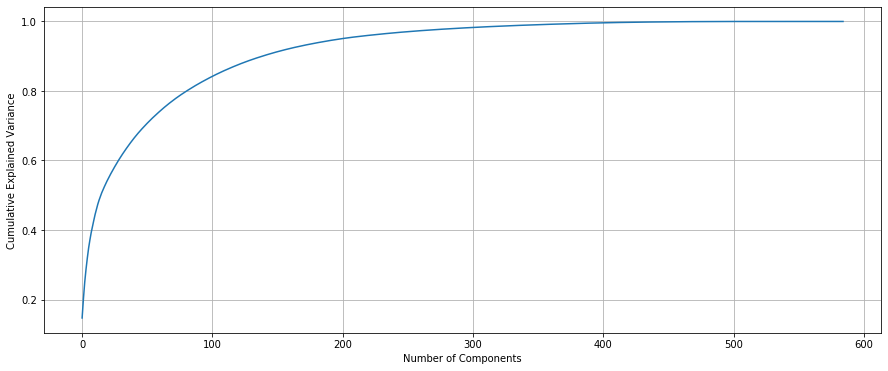

In [9]:
num_components = len(pca.explained_variance_ratio_)
idx = np.arange(num_components)
values = pca.explained_variance_ratio_

plt.figure(figsize=(15, 6))
cums = np.cumsum(values)
plt.plot(idx, cums)
plt.grid()

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

Pick 150 as pca components number, and top 150 components account for more than 90% of total variance


In [6]:
pca_150 = PCA(n_components=150, random_state=23)
azdias_pca_150 = pca_150.fit_transform(azdias_processed)

Save pca models

In [11]:
dump(pca_150, './outputs/pca_150.joblib') 
dump(pca, './outputs/pca.joblib')

['./outputs/pca.joblib']

In [ ]:
# ## Pick 200 as pca components number
# pca_200 = PCA(n_components=200, random_state=23)
# azdias_pca_200 = pca_200.fit_transform(azdias_processed)
# dump(pca_200, './outputs/pca_200.joblib') 

Analyze top 5 components

In [67]:
def display_pca_results(nth_component, columns_names):
#     coeff = np.round(np.abs(pca_150.components_[nth_component, :]), 4)
    coeff = np.abs(pca_150.components_[nth_component, :])
    coeff = np.round(coeff, 5)
    results_df = pd.DataFrame(coeff, columns=['contribution'])
    results_df.index=columns_names
    results_df.sort_values(by='contribution', ascending=False, inplace=True)
    return results_df

In [68]:
columns = list(azdias_processed.columns)
for i in range(5):
    temp =  display_pca_results(i, columns)
    print (f'\nPrincipal Component # {i+1}')
    print (temp.head(10))


Principal Component # 1
                             contribution
D19_GESAMT_ONLINE_QUOTE_12        0.30514
D19_VERSAND_ONLINE_QUOTE_12       0.28691
D19_GESAMT_OFFLINE_DATUM          0.27746
D19_KONSUMTYP                     0.25384
D19_VERSAND_OFFLINE_DATUM         0.25033
D19_VERSAND_DATUM                 0.19096
D19_TELKO_DATUM                   0.18951
D19_VERSAND_ONLINE_DATUM          0.18464
D19_GESAMT_ONLINE_DATUM           0.17497
D19_BANKEN_DATUM                  0.16581

Principal Component # 2
                             contribution
D19_VERSAND_ONLINE_QUOTE_12       0.41015
D19_GESAMT_ONLINE_QUOTE_12        0.40931
D19_GESAMT_DATUM                  0.36253
D19_VERSAND_DATUM                 0.35171
D19_GESAMT_ONLINE_DATUM           0.30124
D19_VERSAND_ONLINE_DATUM          0.26437
D19_KONSUMTYP                     0.12718
D19_GESAMT_OFFLINE_DATUM          0.12598
D19_GESAMT_ANZ_24                 0.11439
D19_VERSAND_ANZ_24                0.11106

Principal Component # 3
 

### Part 1-2: Clustering Analysis

In this part, `k-means` (from `sklearn`) with be applied on pca-transformed data and clustering analysis will be conducted
1. Compute k-means score for different k values, and pick the right k values for following analysis
2. Conduct clustering step to label each sample with the train k-mean model
3. Analysis the discrepancy between general population and customer pool.

Calculate k-means scores for a range of k values

In [12]:
scores = []
for num_k in range(2, 21):
    kmeans = KMeans(n_clusters = num_k, random_state=23).fit(azdias_pca_150)
    scores.append(np.abs(kmeans.score(azdias_pca_150)))

plot k-means scores against cluster numbers

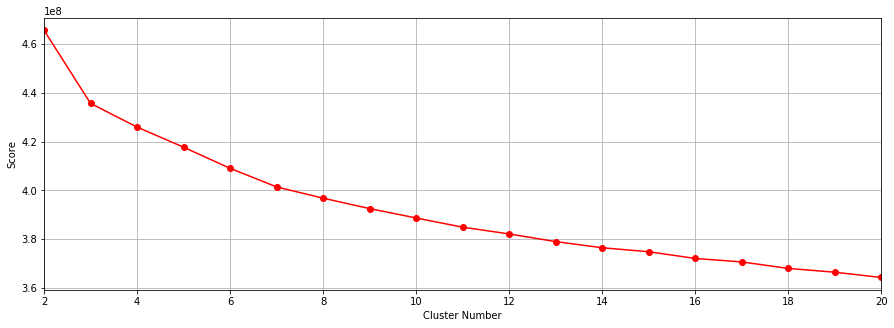

In [13]:
plt.figure(figsize=(15, 5))
plt.plot(list(range(2, 21)), scores, linestyle='-', marker='o', color='r');
plt.xlabel('Cluster Number');
plt.ylabel('Score');
plt.xlim(2, 20)
# plt.margins(x=0.1, y=0.1)
plt.grid()
plt.show()

pick 10 as the cluster number for following processing and analysis

In [7]:
kmeans_10 = KMeans(n_clusters = 10, random_state=23).fit(azdias_pca_150)

In [8]:
dump(kmeans_10, './outputs/kmeans_10.joblib')

['./outputs/kmeans_10.joblib']

extract label for general population

In [9]:
azdias_labels = kmeans_10.labels_

### Apply PCA for custorm data

First, I need to apply the pca model to customer data

In [10]:
customers_pca_150 = pca_150.transform(customers_processed)

calculate label for customer data

In [11]:
customers_labels = kmeans_10.predict(customers_pca_150)

### Compare general population data with customers data

first let's look at the cluster label distribution in general population data

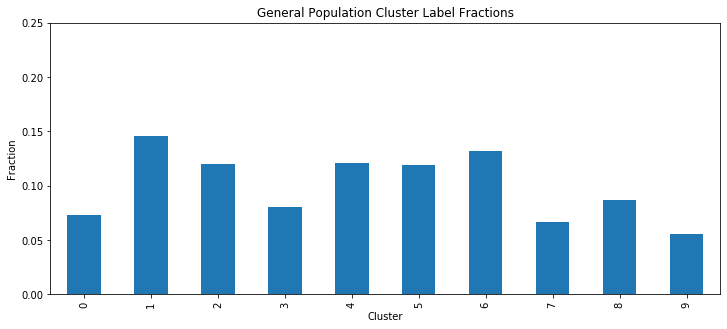

In [12]:
azdias_label_fractions = pd.DataFrame(azdias_labels).loc[:, 0].value_counts().sort_index() / len(azdias_labels)
azdias_label_fractions.plot(kind='bar', figsize=(12, 5))
plt.title('General Population Cluster Label Fractions')
plt.xlabel('Cluster')
plt.ylabel('Fraction')
plt.ylim(0, 0.25)
plt.show()

then let's look at the cluster label distribution in customer data

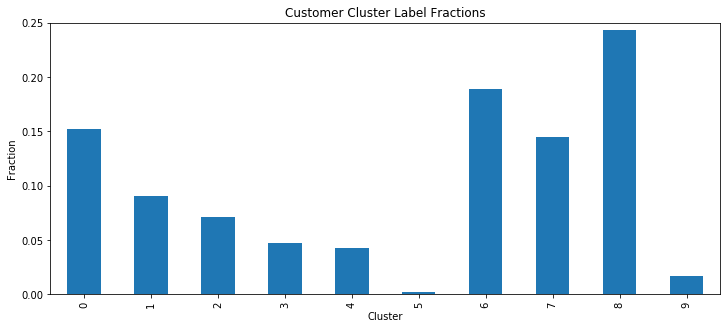

In [13]:
customer_label_fractions = pd.DataFrame(customers_labels).loc[:, 0].value_counts().sort_index()/len(customers_labels)
customer_label_fractions.plot(kind='bar', figsize=(12, 5))
plt.title('Customer Cluster Label Fractions')
plt.xlabel('Cluster')
plt.ylabel('Fraction')
plt.ylim(0, 0.25)
plt.show()

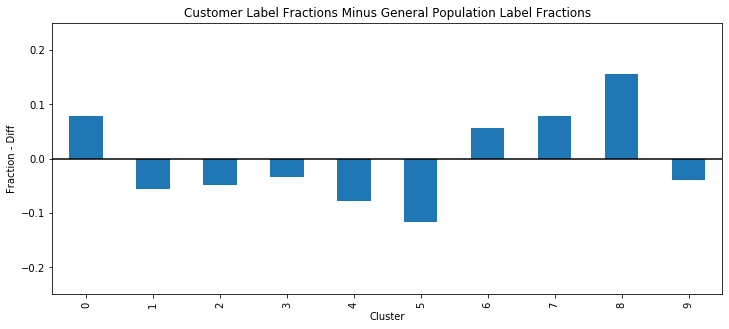

In [14]:
fractions_diff = customer_label_fractions - azdias_label_fractions
fractions_diff.plot(kind='bar', figsize=(12, 5))
plt.axhline(y=0, c='k')
plt.title('Customer Label Fractions Minus General Population Label Fractions')
plt.xlabel('Cluster')
plt.ylabel('Fraction - Diff')
plt.ylim(-0.25, 0.25)
plt.show()

Based on the `Customer Label Fractions Minus General Population Label Fractions` graph, the top 2 clusters which show large difference are cluster #8 and #5

Cluster #8 is over-represented in the customer pool compared to the general population, while cluster #5 is extremely under-represented in the customer pool compared to the general population 

Please use the dataframe before rescaling

In [17]:
azdias_cluster_8 = azdias_select_cols.loc[azdias_labels==8, :]
azdias_cluster_5 = azdias_select_cols.loc[azdias_labels==5, :]

In [18]:
customers_cluster_8 = customers_select_cols.loc[customers_labels==8, :]
customers_cluster_5 = customers_select_cols.loc[customers_labels==5, :]

To Compare the difference between these two clusters,I will plot several attribute distribution between them; meanwhile, I will also plot the distribution between general population and customer to comfirm the effectiveness of clustering steps.

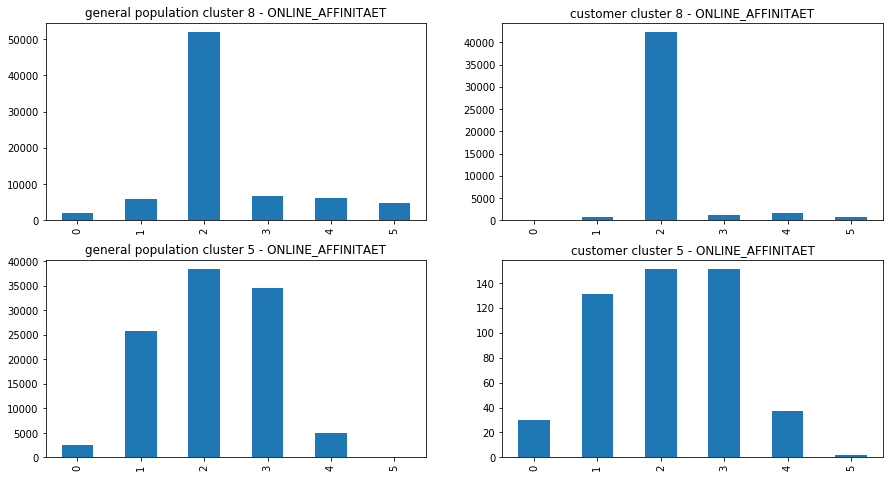

In [19]:
column_of_interest = 'ONLINE_AFFINITAET'
fig, axs = plt.subplots(2, 2, figsize=(15, 8))
azdias_cluster_8[column_of_interest].value_counts().sort_index().plot(
    kind='bar', ax=axs[0][0], title=f'general population cluster 8 - {column_of_interest}')
customers_cluster_8[column_of_interest].value_counts().sort_index().plot(
    kind='bar', ax=axs[0][1], title=f'customer cluster 8 - {column_of_interest}')
azdias_cluster_5[column_of_interest].value_counts().sort_index().plot(
    kind='bar', ax=axs[1][0], title=f'general population cluster 5 - {column_of_interest}')
customers_cluster_5[column_of_interest].value_counts().sort_index().plot(
    kind='bar', ax=axs[1][1], title=f'customer cluster 5 - {column_of_interest}')

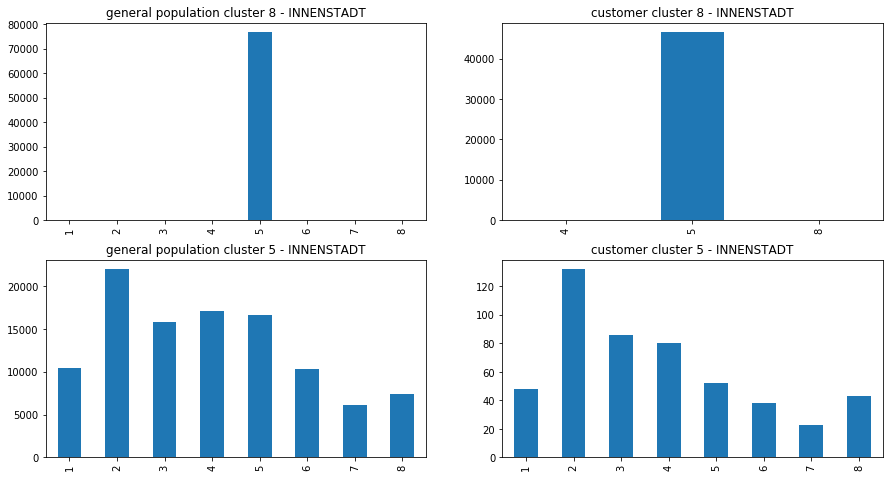

In [20]:
column_of_interest = 'INNENSTADT'
fig, axs = plt.subplots(2, 2, figsize=(15, 8))
azdias_cluster_8[column_of_interest].value_counts().sort_index().plot(
    kind='bar', ax=axs[0][0], title=f'general population cluster 8 - {column_of_interest}')
customers_cluster_8[column_of_interest].value_counts().sort_index().plot(
    kind='bar', ax=axs[0][1], title=f'customer cluster 8 - {column_of_interest}')
azdias_cluster_5[column_of_interest].value_counts().sort_index().plot(
    kind='bar', ax=axs[1][0], title=f'general population cluster 5 - {column_of_interest}')
customers_cluster_5[column_of_interest].value_counts().sort_index().plot(
    kind='bar', ax=axs[1][1], title=f'customer cluster 5 - {column_of_interest}')

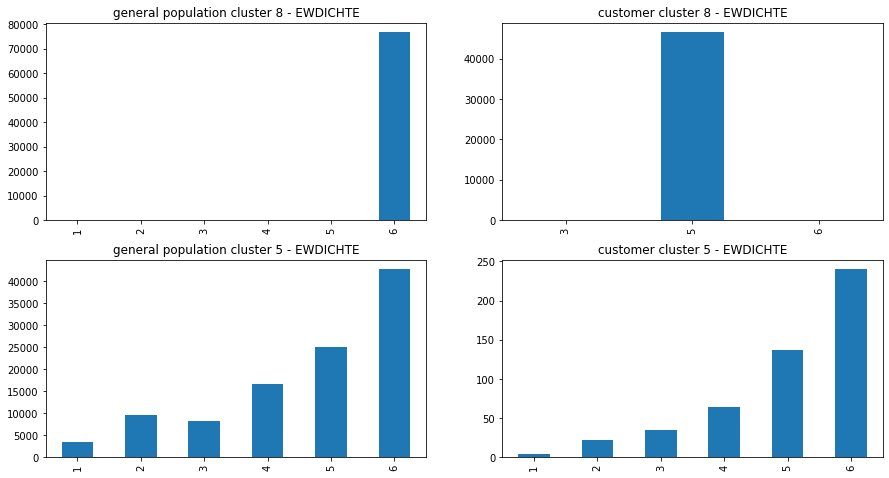

In [21]:
column_of_interest = 'EWDICHTE'
fig, axs = plt.subplots(2, 2, figsize=(15, 8))
azdias_cluster_8[column_of_interest].value_counts().sort_index().plot(
    kind='bar', ax=axs[0][0], title=f'general population cluster 8 - {column_of_interest}')
customers_cluster_8[column_of_interest].value_counts().sort_index().plot(
    kind='bar', ax=axs[0][1], title=f'customer cluster 8 - {column_of_interest}')
azdias_cluster_5[column_of_interest].value_counts().sort_index().plot(
    kind='bar', ax=axs[1][0], title=f'general population cluster 5 - {column_of_interest}')
customers_cluster_5[column_of_interest].value_counts().sort_index().plot(
    kind='bar', ax=axs[1][1], title=f'customer cluster 5 - {column_of_interest}')

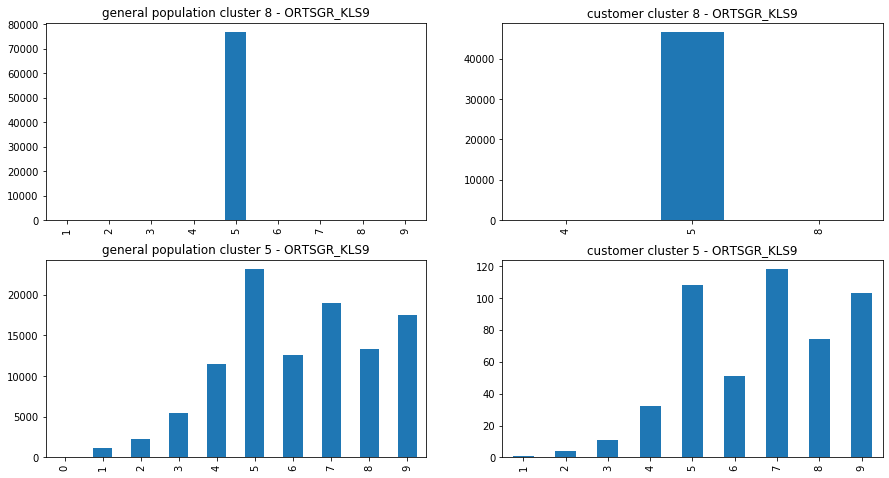

In [22]:
column_of_interest = 'ORTSGR_KLS9'
fig, axs = plt.subplots(2, 2, figsize=(15, 8))
azdias_cluster_8[column_of_interest].value_counts().sort_index().plot(
    kind='bar', ax=axs[0][0], title=f'general population cluster 8 - {column_of_interest}')
customers_cluster_8[column_of_interest].value_counts().sort_index().plot(
    kind='bar', ax=axs[0][1], title=f'customer cluster 8 - {column_of_interest}')
azdias_cluster_5[column_of_interest].value_counts().sort_index().plot(
    kind='bar', ax=axs[1][0], title=f'general population cluster 5 - {column_of_interest}')
customers_cluster_5[column_of_interest].value_counts().sort_index().plot(
    kind='bar', ax=axs[1][1], title=f'customer cluster 5 - {column_of_interest}')

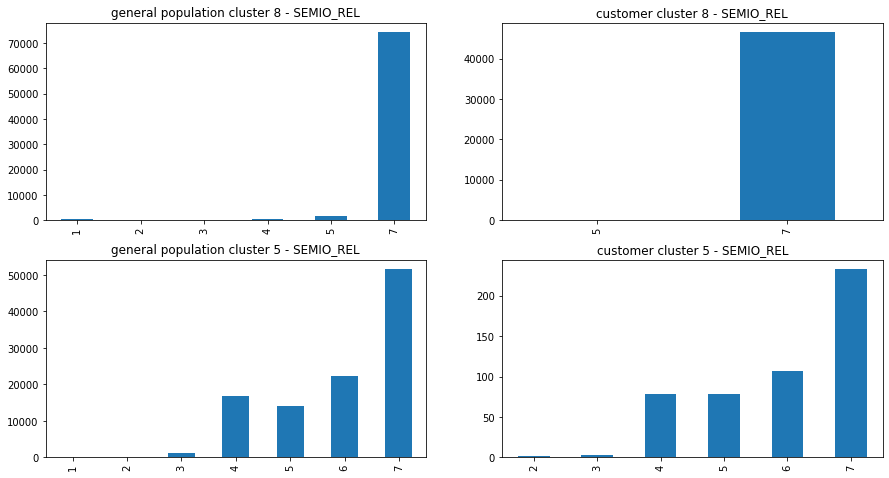

In [23]:
column_of_interest = 'SEMIO_REL'
fig, axs = plt.subplots(2, 2, figsize=(15, 8))
azdias_cluster_8[column_of_interest].value_counts().sort_index().plot(
    kind='bar', ax=axs[0][0], title=f'general population cluster 8 - {column_of_interest}')
customers_cluster_8[column_of_interest].value_counts().sort_index().plot(
    kind='bar', ax=axs[0][1], title=f'customer cluster 8 - {column_of_interest}')
azdias_cluster_5[column_of_interest].value_counts().sort_index().plot(
    kind='bar', ax=axs[1][0], title=f'general population cluster 5 - {column_of_interest}')
customers_cluster_5[column_of_interest].value_counts().sort_index().plot(
    kind='bar', ax=axs[1][1], title=f'customer cluster 5 - {column_of_interest}')

By comparing the value distribution between cluster #8 and #5 (both general population and customer population), we can observe the drastic difference between the two clusters. 

In above comparisons, I chose five features to illustrate the value distribution difference between those two clusters. 

`ONLINE_AFFINITAET`: online affinity \
`INNENSTADT`: distance to city center \
`EWDICHTE`: density of inhabitants per square kilometer \
`ORTSGR_KLS9`: classified number of inhabitants \
`SEMIO_REL`:affinity indicating in what way the person is religious 

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

Since the dataset is quite big, training with all data is slow; for some experiment, only part of the data set is used. 

In [24]:
all_data = False

In [25]:
# load in mailout train dataset
mailout_train = pd.read_csv('./data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

C:\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [26]:
mailout_train_processed = mailout_train_processed.astype('float64')
mailout_train_with_LNR = np.c_[mailout_train.LNR.values, mailout_train_target.values[:, 0], mailout_train_processed]
mailout_train_with_LNR.shape

(42962, 587)

Text(0.5, 1.0, 'Label Distribution')

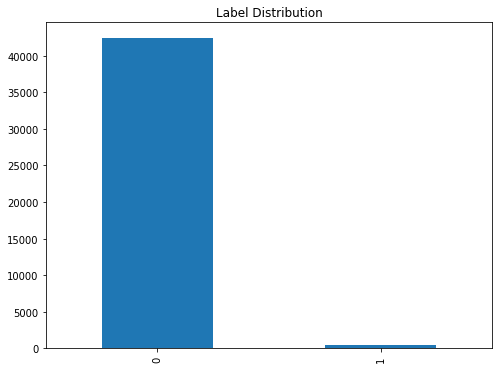

In [35]:
mailout_train_target.RESPONSE.value_counts().plot(kind='bar',figsize=(8, 6))
plt.title('Label Distribution')

If I only use part of the data for modeling, I keep all positive response samples since there are only 532 positive reponses; I will resample negative response samples. 

In [36]:
if not all_data:
    mailout_train_with_LNR_0 = mailout_train_with_LNR[mailout_train_with_LNR[:, 1] == 0, :]
    mailout_train_with_LNR_1 = mailout_train_with_LNR[mailout_train_with_LNR[:, 1] == 1, :]
    print (mailout_train_with_LNR_0.shape)
    print (mailout_train_with_LNR_1.shape)
    np.random.RandomState(seed=23)
    idx_0 = np.random.choice(len(mailout_train_with_LNR_0), 5320, replace=False)
    idx_1 = np.random.choice(len(mailout_train_with_LNR_1), 532, replace=False)
    mailout_train_with_LNR_resampled = np.r_[mailout_train_with_LNR_0[idx_0, :], mailout_train_with_LNR_1[idx_1, :]]
    np.random.RandomState(seed=23)
    np.random.shuffle(mailout_train_with_LNR_resampled)
    mailout_train_with_LNR = mailout_train_with_LNR_resampled

(42430, 587)
(532, 587)


Text(0.5, 1.0, 'Label Distribution After Resampling')

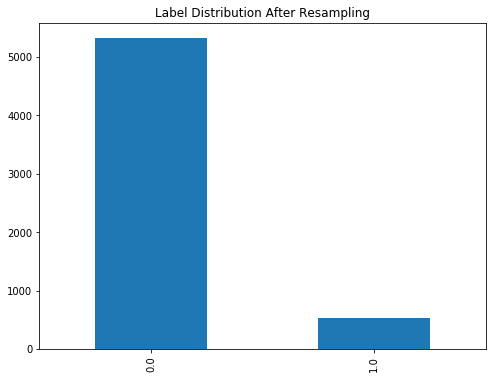

In [49]:
pd.DataFrame(mailout_train_with_LNR[:, 1])[0].value_counts().plot(kind='bar',figsize=(8, 6))
plt.title('Label Distribution After Resampling')

X and y for training data

In [58]:
X = mailout_train_with_LNR[:, 2:]
y = mailout_train_with_LNR[:, 1]

model evaluation function

In [69]:
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.metrics import confusion_matrix

def evaluate_model(X, y, model, cvf=5):
#     cv_scores = cross_val_score(model, X, y, cv=cvf, scoring='roc_auc')
#     print(f'average roc_auc score: {cv_scores.mean()}')
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cvf, scoring = 'roc_auc', 
                                                            train_sizes=np.linspace(.1, 1.0, 10))

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    print(f'average roc_auc score (training): {train_scores_mean[-1]}')
    print(f'average roc_auc score (validation): {test_scores_mean[-1]}')
    plt.grid()

    plt.title('Learning Curve')
    plt.xlabel('training set size (fraction)')
    plt.ylabel('Score')

    plt.plot(np.linspace(.1, 1.0, 10), train_scores_mean, 'o-', label='Training scores')
    plt.plot(np.linspace(.1, 1.0, 10), test_scores_mean, 'o-', label='Validation scores')

    plt.yticks(np.arange(0.45, 1.05, 0.05))
    plt.xticks(np.arange(0., 1.05, 0.1))
    plt.legend()
    plt.show()

### Baseline Model

average roc_auc score (training): 0.8969310046719754
average roc_auc score (validation): 0.7125766331275198


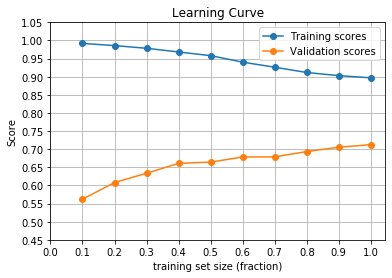

In [70]:
baseline_model = LogisticRegression(penalty='l2', solver='liblinear')
evaluate_model(X, y, baseline_model)

In [173]:
# parameters = {'penalty': ['l1', 'l2'], 'solver': ['lbfgs', 'liblinear']}
# search_baseline = GridSearchCV(cv=5, estimator=LogisticRegression(), param_grid=parameters, scoring = 'roc_auc')
# search_baseline.fit(X, y])

In [71]:
baseline_model = LogisticRegression(penalty='l2', solver='liblinear')
baseline_model.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [72]:
# y_pred = baseline_model.predict(X)
# confusion_matrix(y, y_pred)

### Gradient Boosting Classifier

default parameters

average roc_auc score (training): 0.9212902124465172
average roc_auc score (validation): 0.7535431634764924


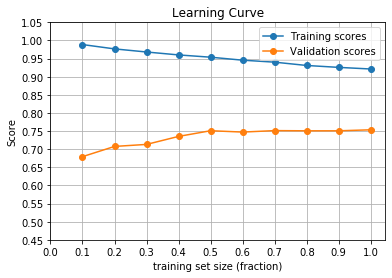

In [74]:
gb_model = GradientBoostingClassifier()
evaluate_model(X, y, gb_model)

grid search to optimize hyperparameters

In [19]:
parameters = {'learning_rate': [0.1, 0.05, 0.01], 'n_estimators': [100, 200], 
              'max_depth': [3, 5], 'min_samples_split': [2, 4, 6]}
search_gb = GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), param_grid=parameters, scoring = 'roc_auc')
search_gb.fit(X, y)
dump(search_gb, './outputs/search_gb.joblib')

['./outputs/search_gb.joblib']

In [161]:
# column_list = ['rank_test_score', 'params', 'mean_test_score', 'mean_train_score']
column_list = ['rank_test_score', 'params', 'mean_test_score']
search_db_results = {key: search_gb.cv_results_[key] for key in search_gb.cv_results_ if key in column_list}

In [185]:
# display grid search results
pd.set_option('display.max_colwidth', -1)
df_results = pd.DataFrame(search_db_results).sort_values('rank_test_score').reset_index(drop=True)
df_results.head(5)

,params,mean_test_score,rank_test_score
0,"{'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 4, 'n_estimators': 100}",0.762529,1
1,"{'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 4, 'n_estimators': 200}",0.762509,2
2,"{'learning_rate': 0.01, 'max_depth': 5, 'min_samples_split': 4, 'n_estimators': 100}",0.762297,3
3,"{'learning_rate': 0.05, 'max_depth': 5, 'min_samples_split': 6, 'n_estimators': 100}",0.762050,4
4,"{'learning_rate': 0.01, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}",0.761917,5


optimized hyperparameters : \
     `learning_rate`: 0.01, \
     `n_estimators`: 100, \
     `max_depth`: 3, \
     `min_samples_split`: 4

In [186]:
gb_model = GradientBoostingClassifier(random_state=23, n_estimators=100,
                                      max_depth=3, learning_rate=0.01, 
                                      min_samples_split=4)
gb_model.fit(X, y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=4,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=23,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [187]:
mailout_test = pd.read_csv('./data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

C:\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [188]:
predictions = gb_model.predict_proba(mailout_test_processed)
mailout_test_pred_with_LNR = np.c_[mailout_test.LNR.values, predictions[:, 1]]

results = pd.DataFrame(mailout_test_pred_with_LNR, columns=['LNR', 'RESPONSE'])
results['LNR'] = results['LNR'].astype('int32')
results.to_csv('./outputs/submission.csv', index=False)